# Background {#sec-background}


## Ritchie Vink, Rust, Apache Arrow and Covid

[Here](https://www.ritchievink.com/blog/2021/02/28/i-wrote-one-of-the-fastest-dataframe-libraries/) is the story, by the creator of Polars.


## Who Can Benefit from Polars?

- Researcher (DS, Analyst, Statistician, etc):
  - Working on their local machine. 
  - Working on a cloud machine (SageMaker, EC2).
- Production system:
  - Running on a dedicated server. 
  - Running on "serverless" (e.g. AWS Lambda, Google Cloud Functions).

## The DataFrame Landscape

Initially there were R's `data.frame`. 
R has evolved, and it now offers `tibble`s and `data.table`s.
Python had only `Pandas` for years. 
Then the Python ecosystem exploded, and now we have:

-  [Pandas](https://Pandas.pydata.org/): The original Python dataframe module. Build by Wes McKinney, on top of numpy.
-  [Polars](https://www.pola.rs/): A new dataframe module, build by Ritchie Vink, on top of Rust and Apache Arrow.
-  [datatable](https://datatable.readthedocs.io/en/latest/): An attempt to recreate R's [data.table](https://github.com/Rdatatable/data.table) API and (crazy) speed in Python. 
-  [Dask](https://www.dask.org/): A distributed computing engine for Python, with support for distributing data over multiple processes running Pandas (or numpy, Polars, etc).
-  [Vaex](https://vaex.io/): A high performance Python library for lazy Out-of-Core DataFrames (similar to dask, but with a different API).
-  [Modin](https://github.com/modin-project/modin): A drop-in distributed  replacement for Pandas, built on top of [Ray](https://www.ray.io/). 
-  [DuckDB](https://duckdb.org/): An embeddable SQL OLAP database management system. These are dataframe that are stored on disk, compute on a single process, and queried with SQL or pythonic API.
- [Daft](https://www.getdaft.io/): A distributed dataframe library built for "Complex Data" (data that doesn't usually fit in a SQL table such as images, videos, documents etc). 
-  [Fugue](https://fugue-tutorials.readthedocs.io/): A dataframe library that allows you to write SQL-like code, and execute it on different backends (e.g. Spark, Dask, Pandas, Polars, etc).
-  [pySpark](https://spark.apache.org/docs/latest/api/python/index.html): The Python API for Spark. Spark is a distributed computing engine, with support for distributing data over multiple processes running Pandas (or numpy, Polars, etc).
-  [CUDF](https://github.com/rapidsai/cudf): A GPU accelerated dataframe library, build on top of Apache Arrow.



See [here](https://pola-rs.github.io/Polars-book/user-guide/misc/alternatives/) and [here](https://www.getdaft.io/projects/docs/en/latest/dataframe_comparison.html) for more details. 





# Motivation {#sec-motivation}

Each of the following, alone(!), is amazing.

1. Small memory footprint.
1. Native dtypes: missing, strings.
2. Lazy evaluation allows query Planning.
3. Streaming engine: No need to load entire dataset into memory.
4. Out of the box parallelism: Fast and informative messages for debugging.
5. Strict typing: This means the dtype of output is defined by the operation and not bu the input. This is both safer, and allows static analysis.


## Setting Up the Environment

At this point you may want to create and activate a [venv](https://realpython.com/python-virtual-environments-a-primer/) for this project. 


In [1]:
# %pip install --upgrade pip
# %pip install --upgrade polars
# %pip install --upgrade pyarrow
# %pip install --upgrade Pandas
# %pip install --upgrade plotly
# %pip freeze > requirements.txt
# %pip install -r requirements.txt

In [2]:
#| label: Polars-version
%pip show Polars # check you Polars version

Name: polars


Version: 0.20.14
Summary: Blazingly fast DataFrame library
Home-page: 
Author: 
Author-email: Ritchie Vink <ritchie46@gmail.com>
License: 
Location: /Users/johnros/workspace/polars_demo/.venv/lib/python3.9/site-packages
Requires: 
Required-by: 


Note: you may need to restart the kernel to use updated packages.


In [3]:
#| label: Pandas-version
%pip show Pandas # check you Polars version

Name: pandas
Version: 2.2.0
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: The Pandas Development Team <pandas-dev@python.org>
License: BSD 3-Clause License
        
        Copyright (c) 2008-2011, AQR Capital Management, LLC, Lambda Foundry, Inc. and PyData Development Team
        All rights reserved.
        
        Copyright (c) 2011-2023, Open source contributors.
        
        Redistribution and use in source and binary forms, with or without
        modification, are permitted provided that the following conditions are met:
        
        * Redistributions of source code must retain the above copyright notice, this
          list of conditions and the following disclaimer.
        
        * Redistributions in binary form must reproduce the above copyright notice,
          this list of conditions and the following disclaimer in the documentation
          and/or other materials 

Note: you may need to restart the kernel to use updated packages.


In [4]:
#| label: preliminaries

import polars as pl
pl.Config(fmt_str_lengths=50)
import polars.selectors as cs

import pandas as pd
import numpy as np
import pyarrow as pa
import plotly.express as px
import string
import random
import os
import sys
%matplotlib inline 
import matplotlib.pyplot as plt
from datetime import datetime

# Following two lines only required to view plotly when rendering from VScode. 
import plotly.io as pio
# pio.renderers.default = "plotly_mimetype+notebook_connected+notebook"
pio.renderers.default = "plotly_mimetype+notebook"

## Memory Footprint

### Memory Footprint of Storage

Comparing Polars to Pandas- the memory footprint of a series of strings. 

Polars. 

In [5]:
letters = pl.Series(list(string.ascii_letters))

n = int(10e6)
letter1 = letters.sample(n,with_replacement=True)
letter1.estimated_size(unit='gb') 

0.14901161193847656

Pandas before Pandas 2.0. 

In [6]:
# Pandas with Ver 1.x backend
letter1_Pandas = letter1.to_pandas(use_pyarrow_extension_array=False) 
letter1_Pandas.memory_usage(deep=True, index=False) / 1e9

0.58

Pandas after Pandas 2.0, with the Pyarrow backend (Apr 2023).

In [7]:
letter1_Pandas = letter1.to_pandas(use_pyarrow_extension_array=True) 
letter1_Pandas.memory_usage(deep=True, index=False) / 1e9

0.09

### Operating From Disk to Disk

What if my data does not fit into RAM? 
Turns out you manifest a lazy frame into disk, instead of RAM, thus avoiding the need to load the entire dataset into memory. 
Alas, the function that does so, [sink_parquet()](https://pola-rs.github.io/Polars/py-Polars/html/reference/lazyframe/api/Polars.LazyFrame.sink_parquet.html), has currently limited functionality. 
It is certainly worth keeping an eye on this function, as it matures.

::: {.callout-note}
Although the potential of `sink_parquet()` is amazing, I find that it currently does not support complicated queries. 
:::


## Lazy Frames and Query Planning {#sec-query-planning}

Consider a sort operation that follows a filter operation. 
Ideally, filter precedes the sort, but we did not ensure this... 
We now demonstrate that Polars' query planner will do it for you. 
En passant, we see Polars is more efficient also without the query planner.


Polars' Eager evaluation in the **wrong** order. 
Sort then filter.


In [8]:
%timeit -n 2 -r 2 letter1.sort().filter(letter1.is_in(['a','b','c']))

491 ms ± 20.1 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Polars' Eager evaluation in the **right** order. 
Filter then sort.


In [9]:
%timeit -n 2 -r 2 letter1.filter(letter1.is_in(['a','b','c'])).sort()

72.2 ms ± 298 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [10]:
latter1_lazy = letter1.alias('letters').to_frame().lazy()

Polars' Lazy evaluation in the **wrong** order; **without** query planning

In [11]:
%timeit -n 2 -r 2 latter1_lazy.sort(by='letters').filter(pl.col('letters').is_in(['a','b','c'])).collect(no_optimization=True)

444 ms ± 6.37 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Polars' Lazy evaluation in the **wrong** order; **with** query planning

In [12]:
%timeit -n 2 -r 2 latter1_lazy.sort(by='letters').filter(pl.col('letters').is_in(['a','b','c'])).collect()

75.9 ms ± 2.68 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Things to note:

1. A lazy evaluation was triggered when `df.lazy()` converted the Polars DataFrame to a Polars LazyFrame.
2. The query planner worked: The Lazy evaluation in the wrong order timed as much as an eager evaluation in the right order; even when accounting for the overhead of converting the frame from eager to lazy.

Now compare to Pandas...

Pandas' eager evaluation in the **wrong** order.


In [13]:
%timeit -n1 -r1 letter1_Pandas.sort_values().loc[lambda x: x.isin(['a','b','c'])]

2.24 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Pandas eager evaluation in the **right** order: Filter then sort.


In [14]:
%timeit -n1 -r1 letter1_Pandas.loc[lambda x: x.isin(['a','b','c'])].sort_values()

134 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Pandas without lambda functions syntax; looks slightly better.


In [15]:
%timeit -n 2 -r 2 letter1_Pandas.loc[letter1_Pandas.isin(['a','b','c'])].sort_values()

131 ms ± 503 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


Things to note:

1. Query planning works!
2. Pandas has dramatically improved since <2.0.0. 
3. Lambda functions are always slow (both Pandas and Polars).


## Optimized for Within-Column Operations

Polars seamlessly parallelizes over columns (also within, when possible). 
As the number of columns in the data grows, we would expect fixed runtime until all cores are used, and then linear scaling. 
The following code demonstrates this idea, using a simple sum-within-column.


In [16]:
# Mac users with Apple silicon (M1 or M2) may also want to benchmark Apples' mlx:
# %pip install mlx
import mlx.core as mx

In [17]:
# Maker an array of floats.
A_numpy = np.random.randn(int(1e6), 10)

A_numpy = A_numpy.copy()
A_Polars = pl.DataFrame(A_numpy)
A_Pandas_numpy = pd.DataFrame(A_numpy)
A_Pandas_arrow = pd.DataFrame(A_numpy, dtype="float32[pyarrow]")
# A_arrow = pa.Table.from_Pandas(A_Pandas_numpy) # no sum method
A_mlx = mx.array(A_numpy)

Candidates currently omited:

1. JAX
2. PyTorch
3. TensorFlow
4. ...?



### Summing Over Columns


In [18]:
%timeit -n 4 -r 2 A_numpy.sum(axis=0)

7.93 ms ± 33 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [19]:
A_numpy.sum(axis=0).shape

(10,)

In [20]:
%timeit -n 4 -r 2 A_Polars.sum()

1.9 ms ± 344 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [21]:
A_Polars.sum().shape

(1, 10)

In [22]:
%timeit -n 4 -r 2 A_mlx.sum(axis=0)

The slowest run took 136.54 times longer than the fastest. This could mean that an intermediate result is being cached.
144 µs ± 142 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [23]:
A_mlx.sum(axis=0).shape

(10,)

### 50 Shades of Pandas

Pandas with numpy backend

In [24]:
%timeit -n 4 -r 2 A_Pandas_numpy.sum(axis=0)

25.5 ms ± 366 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [25]:
A_Pandas_numpy.sum(axis=0).shape

(10,)

Pandas with arrow backend

In [26]:
%timeit -n 4 -r 2 A_Pandas_arrow.sum(axis=0)

3.34 ms ± 473 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [27]:
A_Pandas_arrow.sum(axis=0).shape

(10,)

Pandas with numpy backend, converted to numpy

In [28]:
%timeit -n 4 -r 2 A_Pandas_numpy.values.sum(axis=0)

7.89 ms ± 38.5 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [29]:
A_Pandas_numpy.values.sum(axis=0).shape

(10,)

Pandas with arrow backend, converted to numpy

In [30]:
%timeit -n 4 -r 2 A_Pandas_arrow.values.sum(axis=0)

402 ms ± 13.2 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [31]:
type(A_Pandas_arrow.values)

numpy.ndarray

In [32]:
A_Pandas_arrow.values.sum(axis=0).shape

(10,)

Pandas to mlx

In [33]:
%timeit -n 4 -r 2 mx.array(A_Pandas_numpy.values).sum(axis=0)

4.72 ms ± 2.62 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [34]:
mx.array(A_Pandas_numpy.values).sum(axis=0).shape

(10,)

### Summing Over Rows


In [35]:
%timeit -n 4 -r 2 A_numpy.sum(axis=1)

8.39 ms ± 165 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [36]:
A_numpy.sum(axis=1).shape

(1000000,)

In [37]:
%timeit -n 4 -r 2 A_Polars.sum_horizontal()

5.84 ms ± 278 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [38]:
A_Polars.sum_horizontal().shape

(1000000,)

In [39]:
%timeit -n 4 -r 2 A_mlx.sum(axis=1)

3.68 µs ± 1.66 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


In [40]:
A_mlx.sum(axis=1).shape

(1000000,)

### 50 Shades of Pandas

Pandas with numpy backend

In [41]:
%timeit -n 4 -r 2 A_Pandas_numpy.sum(axis=1)

71.6 ms ± 647 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


Pandas with arrow backend

In [42]:
%timeit -n 4 -r 2 A_Pandas_arrow.sum(axis=1)

193 ms ± 11.2 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


Pandas with numpy backend, converted to numpy

In [43]:
%timeit -n 4 -r 2 A_Pandas_numpy.values.sum(axis=1)

8.53 ms ± 337 µs per loop (mean ± std. dev. of 2 runs, 4 loops each)


Pandas with arrow backend, converted to numpy

In [44]:
%timeit -n 4 -r 2 A_Pandas_arrow.values.sum(axis=1)

415 ms ± 2.5 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


Pandas to mlx

In [45]:
%timeit -n 4 -r 2 mx.array(A_Pandas_numpy.values).sum(axis=1)

4.51 ms ± 1.68 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


## Speed Of Import

Polar's `read_X` functions are quite faster than Pandas. 
This is due to better type "guessing" heuristics, and easier mapping between the disk representation and memory representation of the data.

We benchmark by making synthetic data, save it on disk, and reimporting it.

### CSV Format


In [46]:
n_rows = int(1e5)
n_cols = 10
data_Polars = pl.DataFrame(np.random.randn(n_rows,n_cols))
data_Polars.write_csv('data/data.csv', include_header = False)
f"{os.path.getsize('data/data.csv')/1e7:.2f} MB on disk"

'1.96 MB on disk'

Import with Pandas.


In [47]:
%timeit -n2 -r2 data_Pandas = pd.read_csv('data/data.csv', header = None)

93.2 ms ± 875 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


Import with Polars.


In [48]:
%timeit -n2 -r2 data_Polars = pl.read_csv('data/data.csv', has_header = False)

12.4 ms ± 5.03 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


What is the ratio of times on your machine?
How many cores do you have?




### Parquet Format


In [49]:
data_Polars.write_parquet('data/data.parquet')
f"{os.path.getsize('data/data.parquet')/1e7:.2f} MB on disk"

'0.78 MB on disk'

In [50]:
%timeit -n2 -r2 data_Pandas = pd.read_parquet('data/data.parquet')

The slowest run took 4.80 times longer than the fastest. This could mean that an intermediate result is being cached.
19 ms ± 12.4 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [51]:
%timeit -n2 -r2 data_Polars = pl.read_parquet('data/data.parquet')

5.61 ms ± 1.98 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Feather (Apache IPC) Format


In [52]:
data_Polars.write_ipc('data/data.feather')
f"{os.path.getsize('data/data.feather')/1e7:.2f} MB on disk"

'0.80 MB on disk'

In [53]:
%timeit -n2 -r2 data_Polars = pl.read_ipc('data/data.feather')

The slowest run took 16.37 times longer than the fastest. This could mean that an intermediate result is being cached.
424 µs ± 375 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [54]:
%timeit -n2 -r2 data_Pandas = pd.read_feather('data/data.feather')

3.47 ms ± 1.09 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Pickle Format

In [55]:
import pickle
pickle.dump(data_Polars, open('data/data.pickle', 'wb'))
f"{os.path.getsize('data/data.pickle')/1e7:.2f} MB on disk"

'0.80 MB on disk'

In [56]:
%timeit -n2 -r2 data_Polars = pickle.load(open('data/data.pickle', 'rb'))

2.86 ms ± 804 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Summarizing Import

Things to note:

1. The difference in speed is quite large between Pandas vs. Polars.
1. When dealing with CSV's, the function `pl.read_csv` reads in parallel, and has better type guessing heuristics.
2. The difference in speed is quite large between csv vs. parquet and feather, with feather\<parquet\<csv.
1. Feather is the fastest, but larger on disk. Thus good for short-term storage, and parquet for long-term.
1. The fact that pickle isn't the fastest surprised me; but then again, it is not optimized for data.



## Speed Of Join

Because Pandas is built on numpy, people see it as both an in-memory database, and a matrix/array library. With Polars, it is quite clear it is an in-memory database, and not an array processing library (despite having a `pl.dot()` function for inner products). As such, you cannot multiply two Polars dataframes, but you can certainly join then efficiently.

Make some data:


In [57]:
def make_data(n_rows, n_cols):
  data = np.concatenate(
  (
    np.arange(n_rows)[:,np.newaxis], # index
    np.random.randn(n_rows,n_cols), # values
    ),
    axis=1)
    
  return data


n_rows = int(1e6)
n_cols = 10
data_left = make_data(n_rows, n_cols)
data_right = make_data(n_rows, n_cols)

data_left.shape

(1000000, 11)

### Polars Join


In [58]:
data_left_Polars = pl.DataFrame(data_left)
data_right_Polars = pl.DataFrame(data_right)

%timeit -n2 -r2 Polars_joined = data_left_Polars.join(data_right_Polars, on = 'column_0', how = 'left')

44.5 ms ± 11.2 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Pandas Join


In [59]:
data_left_Pandas = pd.DataFrame(data_left)
data_right_Pandas = pd.DataFrame(data_right)

%timeit -n2 -r2 Pandas_joined = data_left_Pandas.merge(data_right_Pandas, on = 0, how = 'inner')

89.4 ms ± 2.85 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


## The NYC Taxi Dataset {#sec-nyc_taxi}

Empirical demonstration:
Load the celebrated NYC taxi dataset, filter some rides and get the mean `tip_amount` by `passenger_count`.


In [60]:
path = 'data/NYC' # Data from https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
file_names = os.listdir(path)

### Pandas

`df.query()` syntax.

In [61]:
%%time 
taxi_Pandas = pd.read_parquet(path)

query = '''
    passenger_count > 0 and 
    passenger_count < 5 and  
    trip_distance >= 0 and 
    trip_distance <= 10 and 
    fare_amount >= 0 and 
    fare_amount <= 100 and 
    tip_amount >= 0 and 
    tip_amount <= 20 and 
    total_amount >= 0 and 
    total_amount <= 100
    '''.replace('\n', '')
taxi_Pandas.query(query).group_by('passenger_count').agg({'tip_amount':'mean'})

AttributeError: 'DataFrame' object has no attribute 'group_by'

Well, the `df.loc[]` syntax is usually faster than the `query` syntax:


In [62]:
%%time 
taxi_Pandas = pd.read_parquet(path)

ind = (
    taxi_Pandas['passenger_count'].between(1,4) 
    & taxi_Pandas['trip_distance'].between(0,10) 
    & taxi_Pandas['fare_amount'].between(0,100) 
    & taxi_Pandas['tip_amount'].between(0,20) 
    & taxi_Pandas['total_amount'].between(0,100)
)
(
    taxi_Pandas[ind]
    .groupby('passenger_count')
    .agg({'tip_amount':'mean'})
)

CPU times: user 1.94 s, sys: 1.73 s, total: 3.67 s
Wall time: 2.21 s


,tip_amount
passenger_count,
1.0,2.843313
2.0,2.844228
3.0,2.777564
4.0,2.648380


### Polars Lazy In Memory {#sec-polars-lazy-in-memory}


In [63]:
%%time 

import pyarrow.dataset as ds
dset = ds.dataset("data/NYC", format="parquet")  # define folder as Pyarrow dataset

q = (
    pl.scan_pyarrow_dataset(dset)
    # pl.read_parquet("data/NYC/*.parquet") # will now work because parquet was created with Int32, and not Int64. 
    .filter(
        pl.col('passenger_count').is_between(1,4),
        pl.col('trip_distance').is_between(0,10),
        pl.col('fare_amount').is_between(0,100),
        pl.col('tip_amount').is_between(0,20),
        pl.col('total_amount').is_between(0,100)
    )
    .group_by('passenger_count')
    .agg(
      pl.col('tip_amount').mean().name.suffix('_mean')
      ) 
    )

q.collect()

CPU times: user 572 ms, sys: 297 ms, total: 869 ms
Wall time: 383 ms


passenger_count,tip_amount_mean
f64,f64
3.0,2.777564
1.0,2.843313
4.0,2.64838
2.0,2.844228


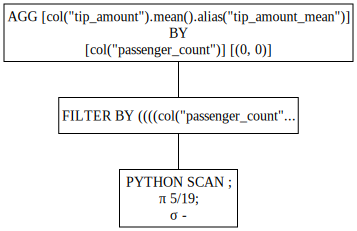

In [64]:
q.show_graph(optimized=True) # Graphviz has to be installed

Things to note:

1. I did not use the native `pl.scan_parquet()` as it is recommended. For your purposes, you will almost always use the native readers. It is convenient to remember, however, that you can also use the PyArrow importers in the native importers fail. 
2. I only have 2 parquet files. When I run the same with more files, despite my 16GB of RAM, **Pandas will crash my python kernel**.
3. From the query graph I see import is done in parallel, and filtering done at scanning time!
4. 



### Polars Lazy From Disk

::: {.callout-important}
The following shows how to use the Polars streaming engine. 
This is arguably the biggest difference with Pandas, and other in memory dataframe libraries.
:::


In [65]:
#| label: Polars-lazy-from-disk

q.collect(streaming=True)

passenger_count,tip_amount_mean
f64,f64
4.0,2.64838
1.0,2.843313
2.0,2.844228
3.0,2.777564


# Preliminaries




## Object Classes

- **Polars Series**: Like a Pandas series. An in-memory array of data, with a name, and a dtype. 

- **Polars Expr**: A Polars series that is not yet computed, and that will be computed when needed.  A Polars Expression can be thought of as:
  1. A Lazy Series: A series that is not yet computed, and that will be computed when needed.
  2. A function: That maps a Polars series to another Polars series (possibly of length 1).

- **Polars LazyFrame**: A collection of Polars Expressions. This is the Polars equivalent of a Spark DataFrame. It is lazy, thus allows query planning.

- **Polars DataFrame**: A collection of Polars Series. This is the Polars equivalent of a Pandas DataFrame. It is eager, and does not allow query planning.
  

::: {.callout-warning}
Not all methods are implemented for all classes. 
In particular, not all `pl.Dataframe` methods are implemented for `pl.LazyFrame` and vice versa. The same goes for `pl.Series` and `pl.Expr`.

This is not because the developers are lazy, but because the API is still being developed, and there are fundamental differences between the classes.

Think about it:

1. Why do we not see a `df.height` attribute for a `pl.LazeFrame`?
2. Why do we not see a `df.sample()` method for a `pl.LazyFrame`?

:::



## Evaluation Engines

Polars seemingly **2 evaluation engines**:

1. **Eager**: This is the default. It is the same as Pandas. When you call a method, the method is immediately executed.
2. **Lazy**: This is the same as Spark. When you call a method, the method is not immediately executed. Instead, a query plan is created. The query plan is then executed when you call `.collect()`.

Why "seemingly" 2? 
Because each engine has it's own subtleties.
For instance, the behavior of the lazy engine may depend on streaming VS non-streaming evaluation, and on the means of loading the data.

1. **Streaming**: This is a special case of lazy evaluation. It is used when you have a large dataset, and you want to process it in chunks. You can then call `.collect(streaming=True)` to process the dataset in chunks. This is useful when you have a dataset that is too large to fit into memory, and you want to process it in chunks. It is also useful when you want to process a dataset in real-time, as it is being generated.
2. **Loading**: Reading multiple parquet files using Polars native readers, may behave slightly different than reading the same files as a Pyarrow dataset (always prefer the native readers, when possible).
  



## Polars dtypes

Polars has its own dtypes, call with `pl.<dtype>`; e.g. `pl.Int32`.
A comprehensive list may be found [here](https://docs.pola.rs/py-Polars/html/reference/datatypes.html).

Here are the most common. 
Note, that unlike Pandas, all are native Polars dtypes, and do not recur to Python objects. 

- Floats: 
  - `pl.Float64`: Arguably, the most frequently used dtype.
- Integers: 
  - `pl.Int64`: The most frequently used integer dtype.
- Booleans: 
  - `pl.Boolean`: As the name suggests. 
- Strings: 
  - `pl.Utf8`: The only string encoding supported by Polars. 
  - `pl.String`: Recently introduced as an alias to `pl.Utf8`.
- Temporal: 
  - `pl.Date`: Date, without time.
  - `pl.Datetime`: Date, with time. 
  - `pl.Time`: Time, without date.
  - `pl.Duration`: Time difference.
- Nulls: 
  - `pl.Null`: Polars equivalent of `None`.
  - `np.nan`: The numpy dtype. Essentially a float, and not as a null.
- Nested:
  - `pl.List`: A list of items.
  - `pl.Array`: Fixed length list. 
  - `pl.Struct`: Think of it as a dict within a frame.



Things to note:

-  Polars has no `Int` dtype, nor `Float`. You must specify the number of bits.
-  Polars recently introduced `pl.String` as an alias for `pl.Utf8`. No other encodings are supported.
-  Polars also supports `np.nan`(!), which is different than its `pl.Null` dtype. `np.nan` is a **float**, and `Null` is a None.
  



## The Polars API

- You will fall in love with it!
- Much more similar to PySpark than to Pandas. The Pandas API is simply not amenable to lazy evaluation. 


### Some Design Principles {#sec-api-principles}

Here are some principles that will help you understand the API:

1. All columns are created equal. There are **no indexing** columns. 

2. Always **remember the class** you are operating on: Is it a series, a dataframe, an expression, or a lazyframe?

5. Operations on the columns of a dataframe will always be part of a **context**. Context may include:
    1. `pl.DataFrame.select()`: This is the most common context. It is used to select columns, and to apply operations on columns.
    2. `pl.DataFrame.with_columns()`: This is used to add columns to a dataframe.
    3. `pl.DataFrame.group_by().agg()`: The `.agg()` context works like a `.select()` context, but it is used to apply operations on sub-groups of rows.
    4. `pl.DataFrame.filter()`: This is used to filter rows using expressions that evaluate to Booleans.

6. Two-word methods are always lower-case, and separated by underscores. E.g: `.is_in()` instead of `.isin()`; `.is_null()` instead of `.isnull()`; `.group_by()` instead of `.group_by()` (starting version 19.0.0). 

7. Polars was designed for operation within **columns**, not within rows. Operations within rows are the exception, and the will have a `_horizontal()` suffix. Examples: `pl.sum_horizontal()`, `pl.mean_horizontal()`, `pl.rolling_sum_horizontal()`.

8. Look for `pl.Expr()` methods so you can chain operations. E.g. `pl.col('a').add(pl.col('b'))` is better than `pl.col('a') + pl.col('b')`; the former can be further chained.
  

### Some Examples of the API

Here is an example to give you a little taste of what the API feels like. 


In [66]:
#| label: Polars-api

# Make some data
polars_frame = pl.DataFrame(make_data(100,4))
polars_frame.limit(5)

column_0,column_1,column_2,column_3,column_4
f64,f64,f64,f64,f64
0.0,1.669047,-0.326934,-1.951628,-0.21938
1.0,0.898881,-0.99467,-1.082106,1.268585
2.0,-0.471933,-1.227642,1.21697,-0.375647
3.0,-1.058041,0.774177,-0.796355,0.344851
4.0,-0.497077,-2.342677,-2.276122,-0.699242


::: {.callout-note}
What is the difference between `.head()` and `limit()`?
For eager frames? For lazy frames?
:::



Can you parse the following in your head?

In [67]:
(
  polars_frame
  .rename({'column_0':'group'})
  .with_columns(
    pl.col('group').cast(pl.Int32),
    pl.col('column_1').ge(0).alias('non-negative'),
  )
  .group_by('non-negative')
  .agg(
    pl.col('group').is_between(1,4).sum().alias('one-to-four'),
    pl.col('^column_[0-9]$').mean().name.suffix('_mean'),
  )
)

non-negative,one-to-four,column_1_mean,column_2_mean,column_3_mean,column_4_mean
bool,u32,f64,f64,f64,f64
true,1,0.759827,0.024952,-0.021888,-0.014504
false,3,-0.836159,-0.021363,-0.081255,-0.109327


Ask yourself:

- What is `polars_frame`? Is it an eager or a lazy Polars dataframe?
- Why is `column_1_mean` when `non-negative=false` indeed non negative?
- What is a Polars expression?
- What is a Polars series?
- How did I create the columns `column_1_mean`...`column_4_mean`?
- How would you have written this in Pandas?


In [68]:
#| label: Polars-api-second-example

(
  polars_frame
  .rename({'column_0':'group'})
  .select(
    pl.col('group').mod(2),

    pl.mean_horizontal(
      pl.col('^column_[0-9]$')
    )
    .name.suffix('_mean')
  )
  .filter(
    pl.col('group').eq(1),
    pl.col('column_1_mean').gt(0)
  )
)

group,column_1_mean
f64,f64
1.0,0.022673
1.0,0.324603
1.0,0.660366
1.0,0.224827
1.0,0.524375
…,…
1.0,0.886574
1.0,0.446373
1.0,0.108046


Try parsing the following in your head:


In [69]:
polars_frame_2 = (
  pl.DataFrame(make_data(100,1))
  .select(
    pl.col('*').name.suffix('_second')
  )
)



(
  polars_frame
  .join(
    polars_frame_2,
    left_on = 'column_0',
    right_on = 'column_0_second',
    how = 'left',
    validate='1:1'
  )
)


column_0,column_1,column_2,column_3,column_4,column_1_second
f64,f64,f64,f64,f64,f64
0.0,1.669047,-0.326934,-1.951628,-0.21938,-0.612633
1.0,0.898881,-0.99467,-1.082106,1.268585,-1.31972
2.0,-0.471933,-1.227642,1.21697,-0.375647,0.751427
3.0,-1.058041,0.774177,-0.796355,0.344851,0.347318
4.0,-0.497077,-2.342677,-2.276122,-0.699242,0.477649
…,…,…,…,…,…
95.0,0.580987,0.500641,-1.1551,0.505653,-0.675634
96.0,1.349532,0.039131,1.543008,-0.113703,0.585072
97.0,1.644299,-0.035973,1.901353,-0.873964,1.521826


Can you parse the following in your head?


In [70]:
polars_frame_3 = pl.DataFrame(make_data(10,1))

(
  polars_frame.lazy()
  .select(
    pl.col('*').name.suffix('_first')
  )
  .with_context(
    polars_frame_3.lazy()
    .select(
      pl.col('*').name.suffix('_third')
    ) 
  )
  .select(
    'column_0_first',

    pl.when(
      pl.col('column_0_first').mod(2).eq(0)
      )
    .then(
      pl.lit(1)
      )
    .otherwise(
      polars_frame_3
      .select(
        pl.last().min()
        )
      )
  )
  .collect(streaming=True)
)

column_0_first,literal
f64,f64
0.0,1.0
1.0,-1.369989
2.0,1.0
3.0,-1.369989
4.0,1.0
…,…
95.0,-1.369989
96.0,1.0
97.0,-1.369989


## Getting Help

Before we dive in, you should be aware of the following references for further help:

1.  A [github page](https://github.com/pola-rs/Polars). It is particular important to subscribe to [release updates](https://github.com/pola-rs/Polars/releases). 
2.  A [user guide](https://pola-rs.github.io/Polars-book/user-guide/index.html).
3.  A very active community on [Discord](https://discord.gg/4UfP5cfBE7).
4.  The [API reference](https://pola-rs.github.io/Polars/py-Polars/html/reference/index.html).
5.  A Stack-Overflow [tag](https://stackoverflow.com/questions/tagged/python-Polars).
6.  Cheat-sheet for [Pandas users](https://www.rhosignal.com/posts/Polars-Pandas-cheatsheet/).

**Warning**: Be careful of AI assistants such as Github-Copilot, TabNine, etc. 
Polars is still very new, and they may give you Pandas completions instead of Polars.





# Polars Series {#sec-series}

A Polars series looks a feels a lot like a Pandas series.
You usually will try to avoid them because: (a) Your objects will usually be in frames, not in series. (b) If in frames, you will be calling `pl.Expr()` methods, and not `pl.Series()` methods. 
Getting used to Polars series, will thus give you bad intuitions when you move to Polars expressions.
Nevertheless, it is the simples object to learn, so we start there. 


Construct a series


In [71]:
#| label: make-a-series
s = pl.Series("a", [1, 2, 3])
s

a
i64
1
2
3


Make Pandas series for later comparisons.


In [72]:
#| label: make-a-Pandas-series
s_Pandas = pd.Series([1, 2, 3], name = "a")
s_Pandas

0    1
1    2
2    3
Name: a, dtype: int64

Notice even the printing to Jupiter is different.


In [73]:
#| label: check-series-type
type(s)

polars.series.series.Series

In [74]:
#| label: check-Pandas-series-type
type(s_Pandas)

pandas.core.series.Series

In [75]:
#| label: check-series-dtype
s.dtype

Int64

In [76]:
#| label: check-Pandas-series-dtype
s_Pandas.dtype

dtype('int64')

Renaming a series; will be very useful when operating on dataframe columns.


In [77]:
#| label: rename-series
s.alias("b")

b
i64
1
2
3


Constructing a series of floats, for later use.


In [78]:
#| label: make-a-float-series
f = pl.Series("a", [1., 2., 3.])
f

a
f64
1.0
2.0
3.0


In [79]:
#| label: check-float-series-dtype
f.dtype

Float64

## Export To Other Python Objects

The current section deals with exports to other python objects, **in memory**. 
See @sec-disk-export for exporting to disk.

Export to Polars DataFrame.

In [80]:
#| label: series-to-Polars-dataframe
s.to_frame() 

a
i64
1
2
3


Export to Python list. 

In [81]:
#| label: series-to-list
s.to_list()

[1, 2, 3]

Export to Numpy array. 

In [82]:
#| label: series-to-numpy
s.to_numpy() # useful for preparing data for learning with scikit-learn

array([1, 2, 3])

Export to Pandas Series. 

In [83]:
#| label: series-to-Pandas-series
s.to_pandas()

0    1
1    2
2    3
Name: a, dtype: int64

Export to Arrow Array.
Useful for preparing data for learning with XGBoost which supports Arrow.
Maybe Scikit-learn will also support Arrow in the future? Although Scikit-learn [may support Polars](https://github.com/scikit-learn/scikit-learn/issues/25896) before it supports Arrow.

In [84]:
#| label: series-to-arrow
s.to_arrow() 

[
  1,
  2,
  3
]

## Memory Representation of Series

Object size in memory. 
Super useful for profiling.
Will only be available for eager objects; by definitions. 


In [85]:
#| label: series-memory-size
s.estimated_size(unit="b") # 8(bytes) * 3(length)

24

## Filtering and Subsetting {#sec-filtering-subsetting-series}


In [86]:
s[0] # same as s.__getitem__(0)

1

To filter, you need to use the `.filter()` method.


In [87]:
#| label: series-filter-with-series
s.filter(pl.Series("a", [True, False, True])) # works

a
i64
1
3


Filtering with the `[` operator will not work:


In [88]:
#| label: series-subset-with-boolean
#| eval: false
s[[True, False, True]]

In [89]:
#| label: series-filter-with-list
s.filter([True, False, True])

a
i64
1
3


In [90]:
#| label: series-limit
s.limit(2)

a
i64
1
2


In [91]:
#| label: series-head
s.head(2)

a
i64
1
2


In [92]:
#| label: series-tail
s.tail(2)

a
i64
2
3


In [93]:
#| label: series-sample
s.sample(2, with_replacement=False)

a
i64
1
2


In [94]:
#| label: series-gather-aka-iloc
s.gather([0, 2]) # same as s[0,2] and Pandas .iloc[[0,2]]

a
i64
1
3


In [95]:
#| label: series-slice
s.slice(1, 2) # same as Pandas .iloc[1:2]

a
i64
2
3


In [96]:
#| label: series-gather-every
s.gather_every(2) # same as Pandas .iloc[::2]

a
i64
1
3


## Aggregations


In [97]:
#| label: series-sum
s.sum()

6

In [98]:
#| label: series-min
s.min()

1

In [99]:
#| label: series-arg-min
s.arg_min()

0

In [100]:
#| label: series-max
s.max()

3

In [101]:
#| label: series-arg-max
s.arg_max()

2

In [102]:
#| label: series-mean
s.mean()

2.0

In [103]:
#| label: series-median
s.median()

2.0

In [104]:
#| label: series-quantile
s.quantile(0.2)

1.0

In [105]:
#| label: series-entropy
s.entropy()

-4.68213122712422

In [106]:
#| label: Polars-series-describe
s.describe() 

statistic,value
str,f64
"""count""",3.0
"""null_count""",0.0
"""mean""",2.0
"""std""",1.0
"""min""",1.0
"""25%""",2.0
"""50%""",2.0
"""75%""",3.0
"""max""",3.0


Polars `pl.series.describe()` is almost the same as Pandas `pd.series.describe()`.


In [107]:
#| label: Pandas-series-describe
s_Pandas.describe()

count    3.0
mean     2.0
std      1.0
min      1.0
25%      1.5
50%      2.0
75%      2.5
max      3.0
Name: a, dtype: float64

In [108]:
#| label: series-value-counts
s.value_counts()

a,count
i64,u32
3,1
1,1
2,1


## Missing

Thanks to Arrow, Polars has built in missing value support for all(!) dtypes. 
This has been a long awaited feature in the Python data science ecosystem with implications on speed, memory, style and more. 
The [Polars User Guide](https://pola-rs.github.io/Polars-book/user-guide/howcani/missing_data.html) has a great overview of the topic from which we collect some take-homes:

- `np.nan` is also supported along `pl.Null`, but is not considered as a missing value by Polars. This has implications on null counts, statistical aggregations, etc.
- `pl.Null`, and `np.nan`s have their own separate functions for imputing, counting, etc.


In [109]:
m = pl.Series("a", [1, 2, None, np.nan])

In [110]:
m.is_null() # checking for None's. Like Pandas .isna()

a
bool
false
false
true
false


In [111]:
m.is_nan() # checking for np.nan's

a
bool
false
false
null
true


For comparison with Pandas:


In [112]:
m_Pandas = pd.Series([1, 2, None, np.nan])

In [113]:
m_Pandas.isna()

0    False
1    False
2     True
3     True
dtype: bool

In [114]:
m_Pandas.isnull() # alias for pd.isna()

0    False
1    False
2     True
3     True
dtype: bool

### Operating on Missing

We now compare the behavior of Polars to Pandas when operating on missing values.
When interpreting the following remember:

1. For Polars, nan is not missing. It is some unknown number. 
2. For Pandas, nan and Nulls are the same. 


In [115]:
# Polars
m1 = pl.Series("a", [1, None, 2, ]) # python native None
m2 = pl.Series("a", [1, np.nan, 2, ]) # numpy's nan
m3 = pl.Series("a", [1, float('nan'), 2, ]) # python's nan

# Pandas
m4 = pd.Series([1, None, 2 ])
m5 = pd.Series([1, np.nan, 2, ])
m6 = pd.Series([1, float('nan'), 2, ])

In [116]:
[
  m1.sum(), 
  m2.sum(), 
  m3.sum(), 
  m4.sum(), 
  m5.sum(), 
  m6.sum(),
  ]

[3, nan, nan, 3.0, 3.0, 3.0]

Things to note:

-   `None` will be ignored by both, which is **unsafe**.
-   `np.nan` will be ignored by Pandas (unsafe), but not by Polars (safe).

Filling missing values; `None` and `np.nan` are treated differently:


In [117]:
#| label: series-fill-null-for-null
m1.fill_null(0)

a
i64
1
0
2


In [118]:
#| label: series-fill-null-for-nan
m2.fill_null(0)

a
f64
1.0
NaN
2.0


In [119]:
#| label: series-fill-nan-for-nan
m2.fill_nan(0)

a
f64
1.0
0.0
2.0


In [120]:
#| label: series-drop-null-for-null
m1.drop_nulls()

a
i64
1
2


In [121]:
#| label: series-drop-nan-for-null
m1.drop_nans()

a
i64
1
null
2


In [122]:
#| label: series-drop-null-for-nan
m2.drop_nulls()

a
f64
1.0
NaN
2.0


In [123]:
#| label: series-interpolate-null-for-null
m1.interpolate()

a
f64
1.0
1.5
2.0


In [124]:
#| label: series-interpolate-null-for-nan
m2.interpolate() # np.nan is not considered missing, so why interpolate?

a
f64
1.0
NaN
2.0


## Shape Transformations


In [125]:
#| label: series-to-dummies
s.to_dummies()

a_1,a_2,a_3
u8,u8,u8
1,0,0
0,1,0
0,0,1


In [126]:
#| label: series-shift
s.shift(1, fill_value=999)

a
i64
999
1
2


In [127]:
#| label: series-shift-back
s.shift(-1)

a
i64
2
3
null


In [128]:
#| label: series-reshape
pl.Series("a",[1,2,3,4]).reshape((2,2))

a
list[i64]
"[1, 2]"
"[3, 4]"


## Arithmetic Operations

The following will fail for `pl.Series` for will work(!) for `pl.Expr`.


In [129]:
#| label: series-add
#| eval: false

s.add(1)

In [130]:
#| label: series-sub
#| eval: false

s.sub(1)

In [131]:
#| label: series-mul
#| eval: false

s.mul(2)

In [132]:
#| label: series-truediv
#| eval: false

s.truediv(2)

In [133]:
#| label: series-floordiv
#| eval: false

s.floordiv(2)

## Mathematical Transformations


In [134]:
#| label: series-abs
s.abs()

a
i64
1
2
3


In [135]:
#| label: series-sin
s.sin()

a
f64
0.841471
0.909297
0.14112


In [136]:
#| label: series-exp
s.exp()

a
f64
2.718282
7.389056
20.085537


In [137]:
#| label: series-hash
s.hash()

a
u64
13306526652308846960
10493018799795767247
7189915626077311336


In [138]:
#| label: series-log
s.log()

a
f64
0.0
0.693147
1.098612


In [139]:
#| label: series-sqrt
s.sqrt()

a
f64
1.0
1.414214
1.732051


## Comparisons


In [140]:
s.equals(pl.Series("a", [1, 2, 3]))

True

In [141]:
#| label: series-eq
s.eq(2)

a
bool
false
true
false


In [142]:
#| label: series-ge
s.ge(2)

a
bool
false
true
true


Clip, aka Winsorize. 


In [143]:
#| label: series-clip
f.clip(lower_bound=1.5,upper_bound=2.5)

a
f64
1.5
2.0
2.5


In [144]:
#| label: series-round
f.round(2)

a
f64
1.0
2.0
3.0


In [145]:
#| label: series-ceil
f.ceil()

a
f64
1.0
2.0
3.0


In [146]:
#| label: series-floor
f.floor()

a
f64
1.0
2.0
3.0


In [147]:
#| label: series-which-max
s.peak_max()

a
bool
false
false
true


## Search


In [148]:
#| label: series-search-in-list
s.is_in([1, 10])

a
bool
true
false
false


In [149]:
#| label: series-search-in-range
s.is_between(2, 3, closed='both')

a
bool
false
true
true


## Apply (map_elements)

Applying your own function. 
Also note the informative error message (introduced in Polars Ver 0.18.0) that will try to recommend a more efficient way to do things.


In [150]:
s.map_elements(lambda x: x + 1)

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/2438314803.py:1: PolarsInefficientMapWarning:


Series.map_elements is significantly slower than the native series API.
Only use if you absolutely CANNOT implement your logic otherwise.
Replace this expression...
  - s.map_elements(lambda x: ...)
with this one instead:
  + s + 1




a
i64
2
3
4


Are lambda functions really so much slower?


In [151]:
s1 = pl.Series(np.random.randn(int(1e6)))

Adding 1 with apply:


In [152]:
%timeit -n2 -r2 s1.map_elements(lambda x: x + 1)

136 ms ± 2.05 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


Adding 1 without apply:


In [153]:
%timeit -n2 -r2 s1+1

892 µs ± 126 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


## Cumulative Operations


In [154]:
#| label: series-cum-max
s.cum_max()

a
i64
1
2
3


In [155]:
#| label: series-cumsum
s.cum_sum()

a
i64
1
3
6


In [156]:
#| label: series-cumprod
s.cum_prod()

a
i64
1
2
6


In [157]:
#| label: series-ewm
s.ewm_mean(com=0.5)

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/799281854.py:1: DeprecationWarning:

The default value for `ignore_nulls` for `ewm` methods will change from True to False in the next breaking release. Explicitly set `ignore_nulls=True` to keep the existing behavior and silence this warning.



a
f64
1.0
1.75
2.615385


## Differentiation Operations


In [158]:
#| label: series-diff
s.diff()

a
i64
null
1
1


In [159]:
#| label: series-pct-change
s.pct_change()

a
f64
null
1.0
0.5


## Windowed Operations


In [160]:
#| label: series-rolling-mean

s.rolling_mean(window_size=2)

a
f64
null
1.5
2.5


In [161]:
#| label: series-rolling-sum

s.rolling_sum(window_size=2)

a
i64
null
3
5


In [162]:
#| label: series-rolling-map
s.rolling_map(
  sum, 
  window_size=2)

a
i64
null
3
5


Note:

- `sum` is the `pl.sum()` function. You cannot use arbitrary functions within a `rolling_map()` context. 
- Many rolling functions have been prepared. See the [computations section](https://docs.pola.rs/py-Polars/html/reference/series/computation.html) of the Series class in the official API.



## Logical Aggregations


In [163]:
#| label: make-boolean-series
b = pl.Series("a", [True, True, False])
b.dtype

Boolean

In [164]:
#| label: series-all
b.all()

False

In [165]:
#| label: series-any
b.any()

True

In [166]:
#| label: series-not
b.not_()

a
bool
false
false
true


## Uniques and Duplicates


In [167]:
#| label: series-is-duplicated
s.is_duplicated()

a
bool
false
false
false


In [168]:
#| label: series-is-unique
s.is_unique()

a
bool
true
true
true


In [169]:
#| label: series-n-unique
s.unique() # Same as Pandas drop_duplicates()

a
i64
1
2
3


In [170]:
s.n_unique()

3

In [171]:
pl.Series([1,2,3,4,1]).unique_counts()

""
u32
2
1
1
1


In [172]:
#| label: series-is-first-distinct
s.is_first_distinct() # not sure there is a pl.Expr method 

a
bool
true
true
true


Notes:

- `is_first_distinct()` has had many name changes in the past. It was `is_first()` in Polars 0.18.0, and `is_first_distinct()` in Polars 0.19.0.

- Do not confuse `.is_first_distinct()` with `.first()`. The former is a logical aggregation, and the latter is a series method. 


In [173]:
#| label: first-counter-examples
(
  pl.DataFrame(pl.Series("a",[1,2,3,1]))
  .select(
    pl.col('a').first()
    )
)

a
i64
1


## Casting


In [174]:
s.cast(pl.Int32)

a
i32
1
2
3


Things to note:

-   `cast()` is Polars' equivalent of Pandas' `astype()`.
-   The dtypes to cast to are **Polars** dtypes. Don't try `s.cast("int32")`, `s.cast(np.int32)`, or `s.cast(pd.int)`
-   For a list of dtypes see the official [documentation](see%20https://pola-rs.github.io/Polars/py-Polars/html/reference/datatypes.html).



Find the most efficient dtype for a series; Like Pandas `pd.to_numeric(..., downcast="..."`).


In [175]:
s.shrink_dtype().dtype # 

Int8

Also see [here](http://braaannigan.github.io/software/2022/10/31/Polars-dtype-diet.html).

Shrink the memory allocation to the size of the actual data (in place).


In [176]:
s.shrink_to_fit() 

a
i64
1
2
3


## Ordering and Sorting


In [177]:
#| label: series-sort
s.sort()

a
i64
1
2
3


In [178]:
#| label: series-reverse
s.reverse()

a
i64
3
2
1


In [179]:
#| label: series-rank
s.rank()

a
f64
1.0
2.0
3.0


In [180]:
#| label: series-arg-sort
s.arg_sort() 

a
u32
0
1
2


`arg_sort()` returns the indices that would sort the series. Same as R's `order()`.


In [181]:
sorted_s = s[s.arg_sort()]
(s.sort() == sorted_s).all()

True

In [182]:
#| label: series-shuffle
s.shuffle(seed=1) # random permutation

a
i64
2
1
3


## Date and Time

There are 4 datetime dtypes in Polars:

1.  **Date**: A date, without hours. Generated with `pl.Date()`.
2.  **Datetime**: Date and hours. Generated with `pl.Datetime()`.
3.  **Time**: Hour of day. Generated with `pl.Time()`.
4.  **Duration**: As the name suggests. Similar to `timedelta` in Pandas. Generated with `pl.Duration()`.

::: {.callout-warning}
Python has a sea of modules that support datetimes. 
A partial list includes: [datetime module](https://docs.python.org/3/library/datetime.html), extensions in [dateutil](https://dateutil.readthedocs.io/en/stable/), [numpy](https://numpy.org/doc/stable/reference/arrays.datetime.html), [Pandas](https://Pandas.pydata.org/Pandas-docs/version/1.1/user_guide/timeseries.html), [arrow](https://arrow.readthedocs.io/en/latest/), the deprecated [scikits.timeseries](https://pytseries.sourceforge.net/) and certainly others. 
Be aware of the dtype you are using, and the accompanying methods.
:::


### Time Range


In [183]:
from datetime import datetime, timedelta

date = (
  pl.datetime_range(
    start = datetime(
      year= 2001, month=2, day=2, hour =2, minute=24, second=12), 
    end = datetime(
      year=2002, month=2, day=5, hour =5, minute=34, second=45),
    interval='1s', 
    eager= True, 
  )
  .sample(10)
)

date

literal
datetime[μs]
2001-05-31 16:09:03
2001-06-15 03:52:07
2001-05-11 16:20:39
2001-06-19 02:31:48
2001-06-18 16:39:27
2001-09-12 03:08:14
2001-02-13 11:11:23
2002-01-16 04:46:25
2001-05-31 00:12:40


Things to note:

-   How else could I have constructed this series? What other types are accepted as `start` and `end`?
-   `pl.date_range` may return a series of dtype `Date` or `Datetime`. This depens of the granularity of the inputs.


In [184]:
date.dtype

Datetime(time_unit='us', time_zone=None)

Cast to different time unit. 
May be useful when joining datasets, and the time unit is different.


In [185]:
date.dt.cast_time_unit(time_unit="ms")

literal
datetime[ms]
2001-05-31 16:09:03
2001-06-15 03:52:07
2001-05-11 16:20:39
2001-06-19 02:31:48
2001-06-18 16:39:27
2001-09-12 03:08:14
2001-02-13 11:11:23
2002-01-16 04:46:25
2001-05-31 00:12:40


Datetime methods are accessed with the `.dt` namespace.


### Extract Time Sub-Units


In [186]:
date.dt.second()

literal
i8
3
7
39
48
27
14
23
25
40


In [187]:
date.dt.minute()

literal
i8
9
52
20
31
39
8
11
46
12


In [188]:
date.dt.hour()

literal
i8
16
3
16
2
16
3
11
4
0


In [189]:
date.dt.day()

literal
i8
31
15
11
19
18
12
13
16
31


In [190]:
date.dt.week()

literal
i8
22
24
19
25
25
37
7
3
22


In [191]:
date.dt.weekday()

literal
i8
4
5
5
2
1
3
2
3
4


In [192]:
date.dt.month()

literal
i8
5
6
5
6
6
9
2
1
5


In [193]:
date.dt.year()

literal
i32
2001
2001
2001
2001
2001
2001
2001
2002
2001


In [194]:
date.dt.ordinal_day() # day in year

literal
i16
151
166
131
170
169
255
44
16
151


In [195]:
date.dt.quarter()

literal
i8
2
2
2
2
2
3
1
1
2


### Durations

Equivalent to Pandas `period` dtype.


In [196]:
diffs = date.diff()
diffs

literal
duration[μs]
null
14d 11h 43m 4s
-34d -11h -31m -28s
38d 10h 11m 9s
-9h -52m -21s
85d 10h 28m 47s
-210d -15h -56m -51s
336d 17h 35m 2s
-230d -4h -33m -45s


In [197]:
diffs.dtype

Duration(time_unit='us')

::: {.callout-important}
The extrator of sub-units from a `pl.Duration` has recently changed from `.dt.X()` to `.dt.total_X()`.
:::


In [198]:
diffs.dt.total_seconds()

literal
i64
null
1251784
-2979088
3319869
-35541
7381727
-18201411
29093702
-19888425


In [199]:
diffs.dt.total_minutes()

literal
i64
null
20863
-49651
55331
-592
123028
-303356
484895
-331473


In [200]:
diffs.dt.days()

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/1692501085.py:1: DeprecationWarning:

`days` is deprecated. It has been renamed to `total_days`.



literal
i64
null
14
-34
38
0
85
-210
336
-230


In [201]:
diffs.dt.total_hours()

literal
i64
null
347
-827
922
-9
2050
-5055
8081
-5524


### Date Aggregations

Note that aggregating dates, returns a `datetime` type object.


In [202]:
date.dt.max()

datetime.datetime(2002, 1, 16, 4, 46, 25)

In [203]:
date.dt.min()

datetime.datetime(2001, 2, 13, 11, 11, 23)

I never quite undersootd that is the "average day."

In [204]:
date.dt.mean()

datetime.datetime(2001, 6, 21, 9, 52, 52, 500000)

In [205]:
date.dt.median()

datetime.datetime(2001, 6, 7, 22, 0, 35)

### Date Transformations


In [206]:
date.dt.offset_by(by="-100y")

literal
datetime[μs]
1901-05-31 16:09:03
1901-06-15 03:52:07
1901-05-11 16:20:39
1901-06-19 02:31:48
1901-06-18 16:39:27
1901-09-12 03:08:14
1901-02-13 11:11:23
1902-01-16 04:46:25
1901-05-31 00:12:40


Notice the syntax of `offset_by`. It is similar to R's `lubridate` package.


In [207]:
date.dt.offset_by(by="1y2m20d")

literal
datetime[μs]
2002-06-20 16:11:03
2002-07-05 03:54:07
2002-05-31 16:22:39
2002-07-09 02:33:48
2002-07-08 16:41:27
2002-10-02 03:10:14
2002-03-05 11:13:23
2003-02-05 04:48:25
2002-06-20 00:14:40


In [208]:
date.dt.truncate("1m")

literal
datetime[μs]
2001-05-31 16:09:00
2001-06-15 03:52:00
2001-05-11 16:20:00
2001-06-19 02:31:00
2001-06-18 16:39:00
2001-09-12 03:08:00
2001-02-13 11:11:00
2002-01-16 04:46:00
2001-05-31 00:12:00


In [209]:
date.dt.round(every="1m")

literal
datetime[μs]
2001-05-31 16:09:00
2001-06-15 03:52:00
2001-05-11 16:21:00
2001-06-19 02:32:00
2001-06-18 16:39:00
2001-09-12 03:08:00
2001-02-13 11:11:00
2002-01-16 04:46:00
2001-05-31 00:13:00


### From Date to String


In [210]:
date.dt.to_string("%Y-%m-%d")

literal
str
"""2001-05-31"""
"""2001-06-15"""
"""2001-05-11"""
"""2001-06-19"""
"""2001-06-18"""
"""2001-09-12"""
"""2001-02-13"""
"""2002-01-16"""
"""2001-05-31"""


Or equivalently:

In [211]:
date.dt.strftime("%Y-%m-%d")

literal
str
"""2001-05-31"""
"""2001-06-15"""
"""2001-05-11"""
"""2001-06-19"""
"""2001-06-18"""
"""2001-09-12"""
"""2001-02-13"""
"""2002-01-16"""
"""2001-05-31"""


### From String to Datetime


In [212]:
sd = pl.Series(
    "date",
    [
        "2021-04-22",
        "2022-01-04 00:00:00",
        "01/31/22",
        "Sun Jul  8 00:34:60 2001",
    ],
)
sd

date
str
"""2021-04-22"""
"""2022-01-04 00:00:00"""
"""01/31/22"""
"""Sun Jul 8 00:34:60 2001"""


Parse into `Date` type.


In [213]:
sd.str.to_date(format="%F", strict=False)

date
date
2021-04-22
null
null
null


Or equivalently:

In [214]:
sd.str.strptime(dtype= pl.Date, format="%F", strict=False)

date
date
2021-04-22
null
null
null


In [215]:
sd.str.strptime(pl.Date, "%D", strict=False)

date
date
null
null
2022-01-31
null


Parse into `Datetime` type.


In [216]:
sd.str.to_datetime(format="%F %T", strict=False)

date
datetime[μs]
null
2022-01-04 00:00:00
null
null


Or equivalently:

In [217]:
sd.str.strptime(pl.Datetime, "%F %T", strict=False)

date
datetime[μs]
null
2022-01-04 00:00:00
null
null


In [218]:
sd.str.strptime(pl.Datetime, "%a %h %d %T %Y",strict=False)

date
datetime[μs]
null
null
null
2001-07-08 00:35:00


Parse into `Time` dtype.

In [219]:
sd.str.to_time("%a %h %d %T %Y",strict=False)

date
time
null
null
null
00:35:00


In [220]:
sd.str.strptime(pl.Time, "%a %h %d %T %Y", strict=False)

date
time
null
null
null
00:35:00


## Strings

String methods are accessed with the `.str` namespace.


In [221]:
#| label: make-string-series
st = pl.Series("a", ["foo", "bar", "baz"])

In [222]:
#| label: string-length
st.str.len_chars() # gets number of chars. In ASCII this is the same as lengths()

a
u32
3
3
3


In [223]:
#| label: string-concat
st.str.concat("-")

a
str
"""foo-bar-baz"""


In [224]:
#| label: string-count-matches
st.str.count_matches(pattern= 'o') # count literal matches

a
u32
2
0
0


In [225]:
#| label: string-contains
st.str.contains("foo|tra|bar") 

a
bool
true
true
false


In [226]:
#| label: string-contains-regrex
st.str.contains("ba[a-zA-Z]") 

a
bool
false
true
true


In [227]:
#| label: string-contains-regex-2
st.str.contains("[a-zA-Z]{4,5}") 

a
bool
false
false
false


In [228]:
#| label: string-count-matches-2
st.str.count_matches(pattern='[a-zA-Z]')

a
u32
3
3
3


In [229]:
#| label: string-ends-with
st.str.ends_with("oo")

a
bool
true
false
false


In [230]:
#| label: string-starts-with
st.str.starts_with("fo")

a
bool
true
false
false


To extract the **first** appearance of a pattern, use `extract`:


In [231]:
#| label: sample-strings
url = pl.Series("a", [
            "http://vote.com/ballon_dor?candidate=messi&ref=Polars",

            "http://vote.com/ballon_dor?candidate=jorginho&ref=Polars",

            "http://vote.com/ballon_dor?candidate=ronaldo&ref=Polars"
            ])

In [232]:
#| label: string-extract
url.str.extract("=([a-zA-Z]+)", 1) 
# "=([a-zA-Z]+)" is read: "match an equality, followed by any number of alphanumerics".

a
str
"""messi"""
"""jorginho"""
"""ronaldo"""


To extract **all** appearances of a pattern, use `extract_all`:


In [233]:
#| label: string-extract-all
url.str.extract_all("=(\w+)") # \w is a shorthand for [a-zA-Z0-9_], i.e., alphanumerics and underscore.

a
list[str]
"[""=messi"", ""=Polars""]"
"[""=jorginho"", ""=Polars""]"
"[""=ronaldo"", ""=Polars""]"


In [234]:
#| label: string-pad-end
st.str.pad_end(8, "*")

a
str
"""foo*****"""
"""bar*****"""
"""baz*****"""


In [235]:
#| label: string-pad-start
st.str.pad_start(8, "*")

a
str
"""*****foo"""
"""*****bar"""
"""*****baz"""


In [236]:
#| label: string-strip-char-start
st.str.strip_chars_start('f')

a
str
"""oo"""
"""bar"""
"""baz"""


In [237]:
#| label: string-strip-char-end
st.str.strip_chars_end('r')

a
str
"""foo"""
"""ba"""
"""baz"""


Replacing first appearance of a pattern:


In [238]:
#| label: string-replace
st.str.replace("o+", "ZZ")

a
str
"""fZZ"""
"""bar"""
"""baz"""


Replace all appearances of a pattern:


In [239]:
#| label: string-replace-all
st.str.replace_all("o", "ZZ")

a
str
"""fZZZZ"""
"""bar"""
"""baz"""


String to list of strings. Number of splits inferred.


In [240]:
#| label: string-split
st.str.split(by="o")

a
list[str]
"[""f"", """", """"]"
"[""bar""]"
"[""baz""]"


In [241]:
#| label: string-split-inclusive
st.str.split(by="a", inclusive=True)

a
list[str]
"[""foo""]"
"[""ba"", ""r""]"
"[""ba"", ""z""]"


String to dict of strings. 
Number of **splits** fixed.


In [242]:
#| label: string-split-exact
st.str.split_exact("a", 2)

a
struct[3]
"{""foo"",null,null}"
"{""b"",""r"",null}"
"{""b"",""z"",null}"


String to dict of strings. 
Length of **output** fixed.


In [243]:
#| label: string-split-length
st.str.splitn("a", 4)

a
struct[4]
"{""foo"",null,null,null}"
"{""b"",""r"",null,null}"
"{""b"",""z"",null,null}"


Strip white spaces.


In [244]:
pl.Series(['   ohh   ','   yeah   ']).str.strip()

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/1297794149.py:1: DeprecationWarning:

`strip` is deprecated. It has been renamed to `strip_chars`.



""
str
"""ohh"""
"""yeah"""


In [245]:
#| label: string-to-uppercase
st.str.to_uppercase()

a
str
"""FOO"""
"""BAR"""
"""BAZ"""


In [246]:
#| label: string-to-lowercase
st.str.to_lowercase()

a
str
"""foo"""
"""bar"""
"""baz"""


In [247]:
#| label: string-to-titlecase
st.str.to_titlecase()

a
str
"""Foo"""
"""Bar"""
"""Baz"""


In [248]:
#| label: string-zfill
st.str.zfill(5)

a
str
"""00foo"""
"""00bar"""
"""00baz"""


In [249]:
#| label: string-slice
st.str.slice(offset=1, length=1)

a
str
"""o"""
"""a"""
"""a"""


# Polars (Eager) DataFrames {#sec-dataframes}

Recall :

1.  There is no row index (like R's `data.frame`, `data.table`, and `tibble`; unlike Python's `Pandas`).
2.  Will not accept duplicate column names (unlike Pandas).

## Create

A frame can be created as you would expect. From a dictionary of series, a numpy array, a Pandas sdataframe, or a list of Polars (or Pandas) series, etc.


In [250]:
#| label: make-dataframe

df = pl.DataFrame({
  "integer": [1, 2, 3], 
  "date": [
    (datetime(2022, 1, 1)), 
    (datetime(2022, 1, 2)), 
    (datetime(2022, 1, 3))], 
    "float": [4.0, 5.0, 6.0],
    "string": ["a", "b", "c"]})

## Inspect

Nice HTML printing to iPython. 

In [251]:
df

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [252]:
print(df)

shape: (3, 4)
┌─────────┬─────────────────────┬───────┬────────┐
│ integer ┆ date                ┆ float ┆ string │
│ ---     ┆ ---                 ┆ ---   ┆ ---    │
│ i64     ┆ datetime[μs]        ┆ f64   ┆ str    │
╞═════════╪═════════════════════╪═══════╪════════╡
│ 1       ┆ 2022-01-01 00:00:00 ┆ 4.0   ┆ a      │
│ 2       ┆ 2022-01-02 00:00:00 ┆ 5.0   ┆ b      │
│ 3       ┆ 2022-01-03 00:00:00 ┆ 6.0   ┆ c      │
└─────────┴─────────────────────┴───────┴────────┘


In [253]:
df.glimpse() # useful for wide frames. Similar to R's str() of Pandas's .info()

Rows: 3
Columns: 4
$ integer          <i64> 1, 2, 3
$ date    <datetime[μs]> 2022-01-01 00:00:00, 2022-01-02 00:00:00, 2022-01-03 00:00:00
$ float            <f64> 4.0, 5.0, 6.0
$ string           <str> 'a', 'b', 'c'



In [254]:
df.columns

['integer', 'date', 'float', 'string']

In [255]:
df.shape

(3, 4)

In [256]:
df.height # probably more useful than df.shape[0]

3

In [257]:
df.width

4

In [258]:
df.schema # similar to Pandas info()

OrderedDict([('integer', Int64),
             ('date', Datetime(time_unit='us', time_zone=None)),
             ('float', Float64),
             ('string', String)])

In [259]:
df.with_row_count()

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/354286280.py:1: DeprecationWarning:

`with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.



row_nr,integer,date,float,string
u32,i64,datetime[μs],f64,str
0,1,2022-01-01 00:00:00,4.0,"""a"""
1,2,2022-01-02 00:00:00,5.0,"""b"""
2,3,2022-01-03 00:00:00,6.0,"""c"""


Things to note:

1. `df.schema` and `df.columns` will be available for lazy objects, even before materializing them.
2. `df.height` and `df.shape` will not be available for lazy objects, until they are materialized.

## Intro to Column Operations

::: {.callout-important}
This is probably the most important section of the document.
:::

### Contexts {#sec-contexts}

As discussed in @sec-api-principles, operations on columns will always be done within a **context**.
Pandas fans may think of Polars Context as `.eval()` or `.assign()` Pandas methods.

- `df.with_columns()` to add columns.
- `df.select()` to select columns.
- `df.group_by().agg()` is acutually `.select()` within a `group_by()` context.
- `df.filter()` is a context for filtering rows. 
- `pl.when()` is a context for conditional operations.


Select Context:

In [260]:
#| label: select-context
df.select(pl.col("integer").add(1))

integer
i64
2
3
4


In [261]:
#| label: with-colummns-context
df.with_columns(pl.col("integer").add(1))

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-01 00:00:00,4.0,"""a"""
3,2022-01-02 00:00:00,5.0,"""b"""
4,2022-01-03 00:00:00,6.0,"""c"""


Group-by context:

In [262]:
#| label: group-by-context
df.group_by("string").agg(pl.col("integer").add(1))

string,integer
str,list[i64]
"""a""",[2]
"""c""",[4]
"""b""",[3]


### Column Access

Within a context there are many ways to access a column.
Here are some examples of various ways of adding 1 to the integer column.


In [263]:
#| label: add-1-to-column
#| lst-label: col-ref
#| lst-cap: Referencing a Column in a Select Context
df.select(pl.col("integer").add(1))

integer
i64
2
3
4


In [264]:
df.select(pl.col(["integer"]).add(1))

integer
i64
2
3
4


In [265]:
df.select(pl.col(r"^integer$").add(1))

integer
i64
2
3
4


In [266]:
df.select(pl.col(pl.Int64).add(1))

integer
i64
2
3
4


In [267]:
df.select(pl.first().add(1))

integer
i64
2
3
4


In [268]:
import polars.selectors as cs

df.select(cs.by_name("integer").add(1))

integer
i64
2
3
4


In [269]:
df.select(cs.ends_with("ger").add(1))

integer
i64
2
3
4


In [270]:
df.select(cs.starts_with('int').add(1))

integer
i64
2
3
4


In [271]:
df.select(cs.integer().add(1))

integer
i64
2
3
4


In [272]:
df.select(cs.first().add(1))

integer
i64
2
3
4


In [273]:
df.select(cs.matches(r"^integer$").add(1))

integer
i64
2
3
4


In [274]:
df.select(cs.contains("int").add(1))

integer
i64
2
3
4


In [275]:
df.select(pl.col("integer")+1)

integer
i64
2
3
4


In [276]:
df['integer']+1

integer
i64
2
3
4


In [277]:
df.get_column('integer')+1

integer
i64
2
3
4


The following will not work because a series does not have a `.add(1)` method.

In [278]:
#| eval: false
df['integer'].add(1)
df.get_column('integer').add(1)

::: {.callout-important}
Think: What are the differences between these methods?
:::

My preferred syntax is @col-ref, which is the one I will use in the rest of the document.












## Convert to Other Python Objects

You can always convert your `pl.Series` or `pl.DataFrame` to other Python objects.

To Pandas DataFrame

In [279]:
#| label: dataframe-to-Pandas
df.to_pandas()

,integer,date,float,string
0,1,2022-01-01,4.0,a
1,2,2022-01-02,5.0,b
2,3,2022-01-03,6.0,c


To Numpy Array

In [280]:
#| label: dataframe-to-numpy
df.to_numpy()

array([[1, datetime.datetime(2022, 1, 1, 0, 0), 4.0, 'a'],
       [2, datetime.datetime(2022, 1, 2, 0, 0), 5.0, 'b'],
       [3, datetime.datetime(2022, 1, 3, 0, 0), 6.0, 'c']], dtype=object)

To List of Polars Series

In [281]:
#| label: dataframe-to-list
df.get_columns() # columns as list of Polars series

[shape: (3,)
 Series: 'integer' [i64]
 [
 	1
 	2
 	3
 ],
 shape: (3,)
 Series: 'date' [datetime[μs]]
 [
 	2022-01-01 00:00:00
 	2022-01-02 00:00:00
 	2022-01-03 00:00:00
 ],
 shape: (3,)
 Series: 'float' [f64]
 [
 	4.0
 	5.0
 	6.0
 ],
 shape: (3,)
 Series: 'string' [str]
 [
 	"a"
 	"b"
 	"c"
 ]]

To list of tuples

In [282]:
#| label: dataframe-to-list-of-tuples
df.rows() 

[(1, datetime.datetime(2022, 1, 1, 0, 0), 4.0, 'a'),
 (2, datetime.datetime(2022, 1, 2, 0, 0), 5.0, 'b'),
 (3, datetime.datetime(2022, 1, 3, 0, 0), 6.0, 'c')]

To Dict of Polars Series

In [283]:
#| label: dataframe-to-dict-of-series
df.to_dict() # columns as dict of Polars series

{'integer': shape: (3,)
 Series: 'integer' [i64]
 [
 	1
 	2
 	3
 ],
 'date': shape: (3,)
 Series: 'date' [datetime[μs]]
 [
 	2022-01-01 00:00:00
 	2022-01-02 00:00:00
 	2022-01-03 00:00:00
 ],
 'float': shape: (3,)
 Series: 'float' [f64]
 [
 	4.0
 	5.0
 	6.0
 ],
 'string': shape: (3,)
 Series: 'string' [str]
 [
 	"a"
 	"b"
 	"c"
 ]}

To Dict of Python Lists

In [284]:
#| label: dataframe-to-dict-of-lists
df.to_dict(as_series=False) # columns as dict of Polars series

{'integer': [1, 2, 3],
 'date': [datetime.datetime(2022, 1, 1, 0, 0),
  datetime.datetime(2022, 1, 2, 0, 0),
  datetime.datetime(2022, 1, 3, 0, 0)],
 'float': [4.0, 5.0, 6.0],
 'string': ['a', 'b', 'c']}

To String Representation (`repr`)

In [285]:
#| label: dataframe-to-repr
df.to_init_repr()

'pl.DataFrame(\n    [\n        pl.Series("integer", [1, 2, 3], dtype=pl.Int64),\n        pl.Series("date", [datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2022, 1, 2, 0, 0), datetime.datetime(2022, 1, 3, 0, 0)], dtype=pl.Datetime(time_unit=\'us\', time_zone=None)),\n        pl.Series("float", [4.0, 5.0, 6.0], dtype=pl.Float64),\n        pl.Series("string", [\'a\', \'b\', \'c\'], dtype=pl.String),\n    ]\n)\n'

To a Polars Series of Polars Struct

In [286]:
#| label: dataframe-to-struct
df.to_struct()

""
struct[4]
"{1,2022-01-01 00:00:00,4.0,""a""}"
"{2,2022-01-02 00:00:00,5.0,""b""}"
"{3,2022-01-03 00:00:00,6.0,""c""}"


To PyArrow Table

In [287]:
#| label: dataframe-to-arrow
df.to_arrow()

pyarrow.Table
integer: int64
date: timestamp[us]
float: double
string: large_string
----
integer: [[1,2,3]]
date: [[2022-01-01 00:00:00.000000,2022-01-02 00:00:00.000000,2022-01-03 00:00:00.000000]]
float: [[4,5,6]]
string: [["a","b","c"]]

## Statistical Aggregations


In [288]:
#| label: dataframe-describe
df.describe()

statistic,integer,date,float,string
str,f64,str,f64,str
"""count""",3.0,"""3""",3.0,"""3"""
"""null_count""",0.0,"""0""",0.0,"""0"""
"""mean""",2.0,"""2022-01-02 00:00:00""",5.0,null
"""std""",1.0,null,1.0,null
"""min""",1.0,"""2022-01-01 00:00:00""",4.0,"""a"""
"""25%""",2.0,"""2022-01-02 00:00:00""",5.0,null
"""50%""",2.0,"""2022-01-02 00:00:00""",5.0,null
"""75%""",3.0,"""2022-01-03 00:00:00""",6.0,null
"""max""",3.0,"""2022-01-03 00:00:00""",6.0,"""c"""


Compare to Pandas: Polars will summarize all columns even if they are not numeric.


In [289]:
#| label: dataframe-describe-pandas
df.to_pandas().describe()

,integer,date,float
count,3.0,3,3.0
mean,2.0,2022-01-02 00:00:00,5.0
min,1.0,2022-01-01 00:00:00,4.0
25%,1.5,2022-01-01 12:00:00,4.5
50%,2.0,2022-01-02 00:00:00,5.0
75%,2.5,2022-01-02 12:00:00,5.5
max,3.0,2022-01-03 00:00:00,6.0
std,1.0,NaN,1.0


Statistical aggregations operate column-wise (and in parallel!).

In [290]:
#| label: dataframe-max
df.max()

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""


In [291]:
#| label: dataframe-min
df.min()

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""


In [292]:
#| label: dataframe-mean
df.mean()

integer,date,float,string
f64,datetime[μs],f64,str
2.0,2022-01-02 00:00:00,5.0,null


In [293]:
#| label: dataframe-median
df.median()

integer,date,float,string
f64,datetime[μs],f64,str
2.0,2022-01-02 00:00:00,5.0,null


In [294]:
#| label: dataframe-quantile
df.quantile(0.1)

integer,date,float,string
f64,datetime[μs],f64,str
1.0,null,4.0,null


In [295]:
#| label: dataframe-sum
df.sum()

integer,date,float,string
i64,datetime[μs],f64,str
6,null,15.0,null


Constrast with summation in row:

In [296]:
#| label: dataframe-sum-horizontal
df.with_columns(pl.sum_horizontal('*'))

integer,date,float,string
str,datetime[μs],f64,str
"""16409952000000014.0a""",2022-01-01 00:00:00,4.0,"""a"""
"""16410816000000025.0b""",2022-01-02 00:00:00,5.0,"""b"""
"""16411680000000036.0c""",2022-01-03 00:00:00,6.0,"""c"""


## Selections {#sec-filtering-subsetting-frames}

1.  If you are used to Pandas, recall there is no index. There is thus no need for `loc` vs. `iloc`, `reset_index()`, etc. See [here](https://pola-rs.github.io/Polars-book/user-guide/howcani/selecting_data/selecting_data_indexing.html) for a comparison of extractors between Polars and Pandas.
2.  Filtering and selection is possible with the `[` operator, or the `filter()` and `select()` methods. The latter is recommended to facilitate query planning (discussed in @sec-query-planning).

### Selecting With Indices

The following are presented for completeness. 
Gnerally, you can, and should, avoid selecting with indices. 
See @sec-selecting-columns for selecting columns, and @sec-filtering-rows for selecting rows.


In [297]:
#| label: single-cell-extraction
df[0,0] # like Pandas .iloc[]

1

Slicing along rows.

In [298]:
#| label: slice-rows
df[0:1] 

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""


Slicing along columns.


In [299]:
#| label: slice-columns
df[:,0:1]

integer
i64
1
2
3


### Selecting Columns {#sec-selecting-columns}

First- do you want to return a Polars frame or a Polars series?

For a frame:

In [300]:
df.select("integer")

integer
i64
1
2
3


For a series:

In [301]:
df['integer']

integer
i64
1
2
3


How do I know which is which? 

1. You can use `type()`.
2. Notice the dimension of the index in the output. 


Select columns with list of labels


In [302]:
df.select(["integer", "float"])

integer,float
i64,f64
1,4.0
2,5.0
3,6.0


As of Polars\>=15.0.0, you don't have to pass a list:


In [303]:
df.select("integer", "float")

integer,float
i64,f64
1,4.0
2,5.0
3,6.0


Column slicing by label

In [304]:
df[:,"integer":"float"]

integer,date,float
i64,datetime[μs],f64
1,2022-01-01 00:00:00,4.0
2,2022-01-02 00:00:00,5.0
3,2022-01-03 00:00:00,6.0


Note: `df.select()` does not support slicing ranges such as `df.select("integer":"float")`. 

Get a column as a Polars Series.

In [305]:
df.get_column('integer')

integer
i64
1
2
3


Get a column as a Polars series.

In [306]:
df.to_series(0)

integer
i64
1
2
3


In [307]:
df.get_column_index('float')

2

In [308]:
df.drop("integer")

date,float,string
datetime[μs],f64,str
2022-01-01 00:00:00,4.0,"""a"""
2022-01-02 00:00:00,5.0,"""b"""
2022-01-03 00:00:00,6.0,"""c"""


`df.drop()` not have an `inplace` argument. Use `df.drop_in_place()` instead.



### pl.col()

The `pl.col()` is **super important**. It allows you to select columns in many ways, and provides almost all the methods (i.e. Polars Expressions) you will need to operate on them. 


In [309]:
df.select(pl.col(pl.Int64))

integer
i64
1
2
3


In [310]:
df.select(pl.col(pl.Float64))

float
f64
4.0
5.0
6.0


In [311]:
df.select(pl.col(pl.Utf8))

string
str
"""a"""
"""b"""
"""c"""


Python List of Polars dtypes

In [312]:
df.select(pl.col([pl.Int64, pl.Float64]))

integer,float
i64,f64
1,4.0
2,5.0
3,6.0


Patterns ("glob")

In [313]:
df.select(pl.col("*")) # same as df.select(pl.all())

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


Regular Expression. Important! Use `pl.col('^<patterh>$')` to match regular expressions.

In [314]:
df.select(pl.col("^\w{4}$")) 

date
datetime[μs]
2022-01-01 00:00:00
2022-01-02 00:00:00
2022-01-03 00:00:00


In [315]:
df.select(pl.col('^.*g$'))

string
str
"""a"""
"""b"""
"""c"""


In [316]:
#| label: pl-col-with-regex
df.select(pl.col("^.*te.*$")) # regex matching anything with a "te"

integer,date
i64,datetime[μs]
1,2022-01-01 00:00:00
2,2022-01-02 00:00:00
3,2022-01-03 00:00:00


You can use `pl.col()` to exclude columns.

In [317]:
df.select(pl.col("*").exclude("integer"))

date,float,string
datetime[μs],f64,str
2022-01-01 00:00:00,4.0,"""a"""
2022-01-02 00:00:00,5.0,"""b"""
2022-01-03 00:00:00,6.0,"""c"""


In [318]:
df.select(pl.col("*").exclude(pl.Float64))

integer,date,string
i64,datetime[μs],str
1,2022-01-01 00:00:00,"""a"""
2,2022-01-02 00:00:00,"""b"""
3,2022-01-03 00:00:00,"""c"""


Exciting! [New API](https://pola-rs.github.io/Polars/py-Polars/html/reference/selectors.html) for column selection. 


In [319]:
#| label: pl-column-selector
import polars.selectors as cs

df.select(cs.starts_with('i'))

integer
i64
1
2
3


In [320]:
#| label: pl-column-selector-set-opeartions

df.select(cs.starts_with('i') | cs.starts_with('d'))

integer,date
i64,datetime[μs]
1,2022-01-01 00:00:00
2,2022-01-02 00:00:00
3,2022-01-03 00:00:00


In [321]:
df.select(cs.starts_with('i') | cs.starts_with('d'))

integer,date
i64,datetime[μs]
1,2022-01-01 00:00:00
2,2022-01-02 00:00:00
3,2022-01-03 00:00:00


### Selecting Rows By Index


In [322]:
df.limit(2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""


In [323]:
df.head(2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""


In [324]:
df.tail(1)

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""


In [325]:
df.take_every(2)

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/2485267278.py:1: DeprecationWarning:

`take_every` is deprecated. It has been renamed to `gather_every`.



integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [326]:
df.slice(offset=1, length=1)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


In [327]:
df.sample(1)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


Because `.sample()` requires row counts, it will not work for lazy objects.


In [328]:
df.row(1) # get row as tuple

(2, datetime.datetime(2022, 1, 2, 0, 0), 5.0, 'b')

### Selecting Rows By Condition {#sec-filtering-rows}

Aka [Projection](https://en.wikipedia.org/wiki/Projection_(relational_algebra)). 

Enter the `df.filter()` context. 


In [329]:
#| label: filter-context
#| lst-label: filter-context
#| lst-cap: Filtering Rows in a DataFrame

df.filter(pl.col("integer").eq(2))

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


Things to note:

- `df.filter()` is a **Polars Context**. 
- It is a **keep** filter, not a **drop** filter: it will evaluate expressions, and return the rows where the expression does not evaluate to `False`. 
-   The `[` operator does not support indexing with boolean such as `df[df["integer"] == 2]`.
-   The `filter()` method is recommended over `[` by the authors of Polars, to facilitate lazy evaluation (discussed later).


An alternative syntax for equality filtering, known as **constraint** in the Polars documentation.


In [330]:
df.filter(integer = 2)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


AND conditions:

In [331]:
#| label: filter-and
df.filter(
  pl.col('integer').eq(2),
  pl.col('float').gt(10)
)

integer,date,float,string
i64,datetime[μs],f64,str


In [332]:
#| label: filter-and-2
df.filter(
  pl.col('integer').eq(2) &
  pl.col('float').gt(10)
)

integer,date,float,string
i64,datetime[μs],f64,str


OR conditions:

In [333]:
#| label: filter-or
df.filter(
  pl.col('integer').eq(2) |
  pl.col('float').gt(10)
)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""


::: {.callout-note}
How would you write an AND, or OR condition, without using the comparison methods `.eq()`, `.gt()`, etc.?
:::


### Selecting From Single Item Frame

Say your operation returned a Polars frame with a single float, which you want to manipulate as a Python float:

In [334]:
#| label: single-item-to-python
pl.DataFrame([1]).item()

1

## Column Transformations 

1. Transformations are done with Polars Expressions (@sec-expressions) within a **context** (see @sec-contexts).
-   The output column will have the same name as the input, unless you use the `alias()` method to rename it.


In [335]:
#| label: with-columns
df.with_columns(
    pl.col("integer").mul(2),
    pl.col("integer").alias("integer2"),
    integer3 = pl.col("integer").truediv(3),
)

integer,date,float,string,integer2,integer3
i64,datetime[μs],f64,str,i64,f64
2,2022-01-01 00:00:00,4.0,"""a""",1,0.333333
4,2022-01-02 00:00:00,5.0,"""b""",2,0.666667
6,2022-01-03 00:00:00,6.0,"""c""",3,1.0


Warning!

In [336]:
#| eval: false
df.with_columns(
    integer3 = pl.col("integer").truediv(3),
    pl.col("integer").mul(2),
    pl.col("integer").alias("integer2"),
)

Things to note:

-   You cannot use `[` to assign! This would not have worked `df['integer3'] = df['integer'] * 2`
-   The columns `integer` is multiplied by 2 **in place**, because no `alias` is used.
-   As of Polars version \>15.*.* (I think), you can use `=` to assign. That is how `integer3` is created.
-   The column `integer` is copied, by renaming it to `integer2`.
-   Why `.truediv()`? To distinguish from `.floordiv()` and `.mod()`. See [this issue](https://github.com/pola-rs/polars/issues/12450) for a discussion of the topic. 

If a selection returns multiple columns, all will be transformed:

In [337]:
#| label: with-columns-multiple
df.with_columns(
    pl.col([pl.Int64,pl.Float64]).mul(2)
)

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-01 00:00:00,8.0,"""a"""
4,2022-01-02 00:00:00,10.0,"""b"""
6,2022-01-03 00:00:00,12.0,"""c"""


In [338]:
#| label: with-columns-all-cast
df.with_columns(
    pl.all().cast(pl.Utf8)
)

integer,date,float,string
str,str,str,str
"""1""","""2022-01-01 00:00:00.000000""","""4.0""","""a"""
"""2""","""2022-01-02 00:00:00.000000""","""5.0""","""b"""
"""3""","""2022-01-03 00:00:00.000000""","""6.0""","""c"""


You cannot `.alias()` when operating on multiple columns. But you can use `.name.suffix()` or `.name.prefix()` from the `.name.` namespace.

In [339]:
#| label: with-columns-multiple-2
df.with_columns(
    pl.col([pl.Int64,pl.Float64]).mul(2).name.suffix("_2X")
)

integer,date,float,string,integer_2X,float_2X
i64,datetime[μs],f64,str,i64,f64
1,2022-01-01 00:00:00,4.0,"""a""",2,8.0
2,2022-01-02 00:00:00,5.0,"""b""",4,10.0
3,2022-01-03 00:00:00,6.0,"""c""",6,12.0


### Transform the Transformed Columns

All the expressions within a context see the frame as it's initial state. 
Recall, odds are expressions will be evaluated in parallel, and not sequentially. 
So how can I operate on columns I have just transformed?
By chaining contexts!


In [340]:
#| label: chained-contexts
(
  df
  .with_columns(
    pl.col("integer").truediv(pl.col("float")).alias("ratio")
  )
  .with_columns(
    pl.col("ratio").mul(100)
  )
)

integer,date,float,string,ratio
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",25.0
2,2022-01-02 00:00:00,5.0,"""b""",40.0
3,2022-01-03 00:00:00,6.0,"""c""",50.0


### Conditional Transformation (if-else)


In [341]:
#| label: conditional-transformation
df.with_columns(
    pl.when(
      pl.col("integer").gt(2)
    )
    .then(pl.lit(1))
    .otherwise(pl.col("integer"))
    .alias("new_col")
)

integer,date,float,string,new_col
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",2
3,2022-01-03 00:00:00,6.0,"""c""",1


Things to note:

-  The `otherwise()` method is optional. If omitted, the original column will be returned (see next example).
-  `pl.lit(1)` is a Polars expression that returns the literal 1. It may be ommited, but it is good practice to include it for clarity and safety.
-  `pl.col("integer").gt(2)` could have been replaced with `pl.col("integer") > 2`. I like the former because it allows easier composition of conditions.


In [342]:
df.with_columns(
    pl.when(
      pl.col("integer") > 2
    )
    .then(1)
    .otherwise(pl.col("integer"))
    .alias("new_col")
)

integer,date,float,string,new_col
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",2
3,2022-01-03 00:00:00,6.0,"""c""",1


### Python Lambda Functions

Apply your own lambda function.

In [343]:
df.select([pl.col("integer"), pl.col("float")]).map_rows(lambda x: x[0] + x[1])

map
f64
5.0
7.0
9.0


As usual, using your own functions may have a very serious toll on performance.


In [344]:
df_big = pl.DataFrame(np.random.randn(1000000, 2), schema=["a", "b"]) # previous versions used columns= instead of schema=

In [345]:
%timeit -n2 -r2 df_big.sum_horizontal()

1.43 ms ± 295 µs per loop (mean ± std. dev. of 2 runs, 2 loops each)


In [346]:
%timeit -n2 -r2 df_big.map_rows(lambda x: x[0] + x[1])

225 ms ± 8.92 ms per loop (mean ± std. dev. of 2 runs, 2 loops each)


### Numpy Ufuncs

You can use Numpy's universal functions (ufuncs) on Polars frames. 
There is little overhead in using Numpy ufuncs.

- See [here](https://docs.pola.rs/user-guide/expressions/numpy/) to use Numpy   ufuncs in Polars.
- See [here](https://www.w3schools.com/python/numpy/numpy_ufunc_create_function.asp) to create your own Numpy ufunc's.

Applying off-the-shelf Numpy ufuncs is as simple.


In [347]:
#| label: numpy-ufunc

df.select(pl.col('integer').pipe(np.sin))
# the same as 
# df.select(np.sin(pl.col('integer')))

integer
f64
0.841471
0.909297
0.14112


Writing your own Numpy ufunc is easy. 

In [348]:
#| label: numpy-ufunc-2

def myfunc(x):
  return x**2 + 2*x + 1

# make myfunc a ufunc
myfunc_ufunc = np.frompyfunc(myfunc, 1, 1)

df.select(
  pl.col('float').pipe(myfunc_ufunc, casting='unsafe')
  )

float
f64
25.0
36.0
49.0


Things to note:

- My Ufunc is created with `np.frompyfunc()`. It could have also been created with `np.vectorize()`.
- The `casting='unsafe'` argument is required, to deal with dtype mismatch. There could be a more elegant way, but I did not find it. 
- Calling a **Ufunc with multiple arguments** is slightly more involved, and I currently did not find a "clean" solution. 





## Uniques and Duplicates

Keep uniques; same as `pd.drop_duplicates()`.


In [349]:
#| label: dataframe-unique
df.unique() 

integer,date,float,string
i64,datetime[μs],f64,str
2,2022-01-02 00:00:00,5.0,"""b"""
1,2022-01-01 00:00:00,4.0,"""a"""
3,2022-01-03 00:00:00,6.0,"""c"""


Can be used with column subset

In [350]:
#| label: dataframe-unique-subset
df.unique(["integer", "float"])

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""
2,2022-01-02 00:00:00,5.0,"""b"""
1,2022-01-01 00:00:00,4.0,"""a"""


In [351]:
df.is_unique()

""
bool
true
true
true


In [352]:
df.is_duplicated()

""
bool
false
false
false


In [353]:
df.n_unique()

3

## Missing

Make some data with missing. 


In [354]:
#| label: make-dataframe-with-nulls
df_with_nulls = df.with_columns(
    null_1 = pl.Series("missing", [3, None, np.nan]),
    null_2 = pl.Series("missing", [None, 5, 6]),
)

In [355]:
#| label: dataframe-with-nulls
df_with_nulls.null_count() # same as pd.isnull().sum()

integer,date,float,string,null_1,null_2
u32,u32,u32,u32,u32,u32
0,0,0,0,1,1


In [356]:
#| label: df-drop-nulls
df_with_nulls.drop_nulls() # same as pd.dropna()

integer,date,float,string,null_1,null_2
i64,datetime[μs],f64,str,f64,i64
3,2022-01-03 00:00:00,6.0,"""c""",NaN,6


Can I also drop `np.nan`'s? 
There is no `drop_nan()` method. 
See [StackOverflow](https://stackoverflow.com/questions/75548444/Polars-dataframe-drop-nans) for workarounds.


In [357]:
#| label: df-fill-nulls
df_with_nulls.fill_null(0) # same as pd.fillna(0)

integer,date,float,string,null_1,null_2
i64,datetime[μs],f64,str,f64,i64
1,2022-01-01 00:00:00,4.0,"""a""",3.0,0
2,2022-01-02 00:00:00,5.0,"""b""",0.0,5
3,2022-01-03 00:00:00,6.0,"""c""",NaN,6


But recall that `None` and `np.nan` are not the same thing.

In [358]:
#| label: df-fill-nans
df_with_nulls.fill_nan(99)

integer,date,float,string,null_1,null_2
i64,datetime[μs],f64,str,f64,i64
1,2022-01-01 00:00:00,4.0,"""a""",3.0,null
2,2022-01-02 00:00:00,5.0,"""b""",null,5
3,2022-01-03 00:00:00,6.0,"""c""",99.0,6


In [359]:
#| label: df-null-interpolate
df_with_nulls.interpolate()

integer,date,float,string,null_1,null_2
f64,datetime[μs],f64,str,f64,f64
1.0,2022-01-01 00:00:00,4.0,"""a""",3.0,null
2.0,2022-01-02 00:00:00,5.0,"""b""",NaN,5.0
3.0,2022-01-03 00:00:00,6.0,"""c""",NaN,6.0


## Sorting


In [360]:
df.sort(by=["integer","float"])

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""


In [361]:
df.reverse()

integer,date,float,string
i64,datetime[μs],f64,str
3,2022-01-03 00:00:00,6.0,"""c"""
2,2022-01-02 00:00:00,5.0,"""b"""
1,2022-01-01 00:00:00,4.0,"""a"""


## Groupby

High level:

-   `df.group_by()` is a **context**, for grouping. Just like Pandas, only parallelized, etc. The output will have as many rows as the number of groups.
-   `df.partion_by()` will return a **list** of frames.
-   `pl.col().expression().over()` is like Pandas `df.groupby.transform()`: will will not collapse rows in the original frame. Rather, it will assign each row in the original frame with the aggregate in the group. The output will have the same number of rows as the input. 

Grouping over time:

-   `df.grouby_rolling()` for rolling window grouping, a.k.a. a sliding window. Each row will be assigned the aggregate in the window.
-   `df.group_by_dynamic()` for dynamic grouping. Each period will be assigned the agregate in the period. The output may have more rows than the input.



The `group_by()` context will be followed by an aggregation:

1.   `df.group_by().agg()`: an aggregating context. 
2.   `df.group_by().apply()`: deprecated and replaced by `df.group_by().map_groups()`.
3.   `df.group_by().map_groups()`: to apply your own function to each group.

See the [API reference](https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.group_by.html) for the various options. 
Also see the [user guide](https://docs.pola.rs/user-guide/transformations/time-series/rolling/) for more details.


In [362]:
df2 = pl.DataFrame({
    "integer": [1, 1, 2, 2, 3, 3],
    "float": [1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    "string": ["a", "b", "c", "c", "d", "d"],
    "datetime": [
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 4)), 
        (datetime(2022, 1, 9)), 
        (datetime(2022, 1, 9)), 
        (datetime(2022, 1, 9))],
})

### partition_by()

Make the list of frames

In [363]:
#| label: partition-by
partitioner = df2.partition_by("integer")
partitioner

[shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ ---   ┆ ---    ┆ ---                 │
 │ i64     ┆ f64   ┆ str    ┆ datetime[μs]        │
 ╞═════════╪═══════╪════════╪═════════════════════╡
 │ 1       ┆ 1.0   ┆ a      ┆ 2022-01-04 00:00:00 │
 │ 1       ┆ 2.0   ┆ b      ┆ 2022-01-04 00:00:00 │
 └─────────┴───────┴────────┴─────────────────────┘,
 shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ ---   ┆ ---    ┆ ---                 │
 │ i64     ┆ f64   ┆ str    ┆ datetime[μs]        │
 ╞═════════╪═══════╪════════╪═════════════════════╡
 │ 2       ┆ 3.0   ┆ c      ┆ 2022-01-04 00:00:00 │
 │ 2       ┆ 4.0   ┆ c      ┆ 2022-01-09 00:00:00 │
 └─────────┴───────┴────────┴─────────────────────┘,
 shape: (2, 4)
 ┌─────────┬───────┬────────┬─────────────────────┐
 │ integer ┆ float ┆ string ┆ datetime            │
 │ ---     ┆ --- 

The iterate like any Python list, with a function that operates on Polars frames:

In [364]:
def myfunc(
  df: pl.DataFrame
  ) -> pl.DataFrame:
  return df.select(pl.col("float").sum())

for df in partitioner: 
  print(myfunc(df))

shape: (1, 1)
┌───────┐
│ float │
│ ---   │
│ f64   │
╞═══════╡
│ 3.0   │
└───────┘
shape: (1, 1)
┌───────┐
│ float │
│ ---   │
│ f64   │
╞═══════╡
│ 7.0   │
└───────┘
shape: (1, 1)
┌───────┐
│ float │
│ ---   │
│ f64   │
╞═══════╡
│ 11.0  │
└───────┘


### group_by()


In [365]:
#| label: group-by
groupper = df2.group_by("integer")

In [366]:
groupper.agg(
  cs.numeric().sum().name.suffix("_sum"),
  pl.col('string').n_unique().name.suffix("_n_unique"),
  pl.col('string'),
)

integer,float_sum,string_n_unique,string
i64,f64,u32,list[str]
3,11.0,1,"[""d"", ""d""]"
2,7.0,1,"[""c"", ""c""]"
1,3.0,2,"[""a"", ""b""]"


Things to note:

- Don't expect an index. This is Polars, not Pandas.
- The grouping may be saved as an object, and used later.
- The `group_by()` and `.agg()` contexts offer the usual functonality of `.select()` and `.with_columns()`. In particular, you can use `pl.col()` to access columns, or the `pl.selector` module (`cs`).
- In the selector is not followed by an expression, it will collapse the Series to a Polars List (see @sec-nested-dtypes). 

Some random/useful examples now follow.

#### Examples

The count (length) of each group:

In [367]:
groupper.agg(pl.len())

integer,len
i64,u32
3,2
2,2
1,2


When operating on all columns,

In [368]:
groupper.len()

integer,len
i64,u32
1,2
2,2
3,2


In [369]:
groupper.sum()

integer,float,string,datetime
i64,f64,str,datetime[μs]
3,11.0,null,null
2,7.0,null,null
1,3.0,null,null


### over()

You may be familar with Pandas `group_by().transform()`, which will return a frame with the same row-count as its input. 
You may be familiar with Postgres SQL [window function](https://www.postgresql.org/docs/current/tutorial-window.html). 
You may not be familiar with neither, and still want to aggregate within group, but propagate the result to all group members. 
Polars' `.over()` is the answer.


In [370]:
#| label: over
df2.with_columns(
  pl.col("float").sum().over("string").alias("sum")
)

integer,float,string,datetime,sum
i64,f64,str,datetime[μs],f64
1,1.0,"""a""",2022-01-04 00:00:00,1.0
1,2.0,"""b""",2022-01-04 00:00:00,2.0
2,3.0,"""c""",2022-01-04 00:00:00,7.0
2,4.0,"""c""",2022-01-09 00:00:00,7.0
3,5.0,"""d""",2022-01-09 00:00:00,11.0
3,6.0,"""d""",2022-01-09 00:00:00,11.0


Things to note:

- The output will have the same number of rows as the input.
- `.over()` is a **context**. As such, you can evaluate column selectors and expressions within it.
- **Careful**: `over()` should be the last operation in a chain. @over-wrong will sadly **not fail**, while it should have.


In [371]:
#| label: over-wrong
#| lst-label: over-wrong
#| lst-cap: A wrong use of over()

df2.with_columns(
  pl.col("float").over("string").sum().alias("sum")
)

integer,float,string,datetime,sum
i64,f64,str,datetime[μs],f64
1,1.0,"""a""",2022-01-04 00:00:00,21.0
1,2.0,"""b""",2022-01-04 00:00:00,21.0
2,3.0,"""c""",2022-01-04 00:00:00,21.0
2,4.0,"""c""",2022-01-09 00:00:00,21.0
3,5.0,"""d""",2022-01-09 00:00:00,21.0
3,6.0,"""d""",2022-01-09 00:00:00,21.0


### Grouping on time

High level:

1. Grouping on time is special, because a temporal variable implies multiple resolutions which may be used for grouping. E.g. a date may be grouped by year, month, day, etc.
2. For a temporal version of `group_by()`, use `df.group_by_dynamic()`.
3. For a temporal version of `over()`, use `df.rolling()`.


In [372]:
#| label: group-by-dynamic
(
  df2
  .sort("datetime")
  .group_by_dynamic(
    index_column="datetime", 
    every="1d",
    )
  .agg(pl.col("float").sum())
)

datetime,float
datetime[μs],f64
2022-01-04 00:00:00,6.0
2022-01-09 00:00:00,15.0


In [373]:
#| label: rolling
(
  df2
  .sort("datetime")
  .rolling(
    index_column="datetime", 
    period='1d',
    )
  .agg(pl.col("float").sum())
)

datetime,float
datetime[μs],f64
2022-01-04 00:00:00,6.0
2022-01-04 00:00:00,6.0
2022-01-04 00:00:00,6.0
2022-01-09 00:00:00,15.0
2022-01-09 00:00:00,15.0
2022-01-09 00:00:00,15.0


## Joins {#sec-joins}

High level:

-   `df.join()` for joins; like Pandas `pd.merge()` or `df.join()`.
-  `df.join_asof()` for asof joins; like Pandas `pd.merge_asof()`.
-   `df.hstack()` for horizontal concatenation; like Pandas `pd.concat([],axis=1)` or R's `cbind`.
-   `df.vstack()` for vertical concatenation; like Pandas `pd.concat([],axis=0)` or R's `rbind`.
-   `df.merge_sorted()` for vertical stacking, with sorting.
-   `pl.concat()`, which is similar to the previous two, but with memory re-chunking. `pl.concat()` also allows diagonal concatenation, if columns are not shared.
-   `df.extend()` for vertical concatenation, but with memory re-chunking. Similar to `df.vstack().rechunk()`.

For more on the differences between these methods, see [here](https://www.rhosignal.com/posts/Polars-extend-vstack/).



### join()


In [374]:
#| label: join

df = pl.DataFrame({
  "integer": [1, 2, 3], 
  "date": [
    (datetime(2022, 1, 1)), 
    (datetime(2022, 1, 2)), 
    (datetime(2022, 1, 3))], 
    "float": [4.0, 5.0, 6.0],
    "string": ["a", "b", "c"]})


df2 = pl.DataFrame({
  "integer": [1, 2, 3], 
  "date": [
    (datetime(2022, 1, 4)), 
    (datetime(2022, 1, 5)), 
    (datetime(2022, 1, 6))], 
    "float":[7.0, 8.0, 9.0],
    "string": ["d", "d", "d"]})


df.join(
  df2, 
  on="integer", 
  how="left",
  validate='m:1'
  )

integer,date,float,string,date_right,float_right,string_right
i64,datetime[μs],f64,str,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a""",2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-02 00:00:00,5.0,"""b""",2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-03 00:00:00,6.0,"""c""",2022-01-06 00:00:00,9.0,"""d"""


Things to note:

-   Repeating column names have been suffixed with "\_right".
-   Recall, there are **no indices**. The `on`/`left_on`/`right_on` argument is always required.
- `how=` may take the following values: 'inner', 'left', 'outer', 'semi', 'anti', 'cross'. 'inner' is the default. 
- I like to add the `validate=` argument, for safety. 
- The join is super fast, as demonstrated in @sec-motivation above.


### join_asof()


In [375]:
df.join_asof(
    df2, 
    left_on="date", 
    right_on='date', 
    by="integer", 
    strategy="backward", 
    tolerance='1w',
    )

integer,date,float,string,float_right,string_right
i64,datetime[μs],f64,str,f64,str
1,2022-01-01 00:00:00,4.0,"""a""",null,null
2,2022-01-02 00:00:00,5.0,"""b""",null,null
3,2022-01-03 00:00:00,6.0,"""c""",null,null


Things to note:

-   Yes! `join_asof()` is available. In streaming engine as well!
-   The `strategy=` argument may take the following values: 'backward', 'forward'.
-   The `tolerance=` argument may take the following values: '1w', '1d', '1h', '1m', '1s', '1ms', '1us', '1ns'.




### hstack

In [376]:
#| label: hstack
new_column = pl.Series("c", np.repeat(1, df.height))

df.hstack([new_column])

integer,date,float,string,c
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",1
3,2022-01-03 00:00:00,6.0,"""c""",1


### vstack

In [377]:
#| label: vstack

df.vstack(df2)

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


Caution: Joining along rows is possible only if matched columns have the same dtype. Timestamps may be tricky because they may have different time units. Recall that timeunits may be cast before joining using `series.dt.cast_time_unit()`. 
Here is a demonstration of the problem:


In [378]:
#| label: vstack-caution
#| eval: false
(
  df
  .vstack(
    df2
    .with_columns(
      pl.col('date').dt.cast_time_unit(time_unit="ms")
      )
    )
)

### merge_sorted

This is a **vertical** stacking, when expecting a sorted result, and assuming inputs are sorted. 


In [379]:
df.merge_sorted(df2, key="integer") 

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-02 00:00:00,5.0,"""b"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-03 00:00:00,6.0,"""c"""
3,2022-01-06 00:00:00,9.0,"""d"""


### concat()

Vertical 

In [380]:
pl.concat([df, df2]) 
# equivalent to:
# pl.concat([df, df2], how='vertical', rechunk=True, parallel=True) 

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


Horizontal

In [381]:
pl.concat(
  [df,new_column.to_frame()], 
  how='horizontal',
  )

integer,date,float,string,c
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",1
2,2022-01-02 00:00:00,5.0,"""b""",1
3,2022-01-03 00:00:00,6.0,"""c""",1


Diagonal

In [382]:
pl.concat(
  [df,new_column.to_frame()], 
  how='diagonal')

integer,date,float,string,c
i64,datetime[μs],f64,str,i64
1,2022-01-01 00:00:00,4.0,"""a""",null
2,2022-01-02 00:00:00,5.0,"""b""",null
3,2022-01-03 00:00:00,6.0,"""c""",null
null,null,null,null,1
null,null,null,null,1
null,null,null,null,1


What is the difference between `pl.concat()` and `df.vstack()` and `hstack()`?
`pl.concat()` is more general with more functionality.

- concat includes re-chunking, which is useful for memory management.
- concat includes diagonal concatenation, which is useful when columns are not shared.
- concat includes parallel execution, which is useful for performance.
- concat has recenetly been equipped with `how=vertial_relaxed` and `how=horizontal_relaxed`, which finds a common dtype if schemas are mismatched.



### extend()

Like `vstack()`, but with memory re-chunking. Similar to `df.vstack().rechunk()`.


In [383]:
df.extend(df2) 

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


Why should I care about re-chunking?
Since Polar is a columnar store, it is important to have contiguous memory layout. Otherwise, you may not enjoy the benefits of vectorized operations. 

Is there a method for `df.hstack().rechunk()`?
No. 
A columnar storage is not sensitive to emory framgmentation along columns.



## Nested dtypes {#sec-nested-dtypes}

Recall the nested dtypes:

1. Polars Struct: Like a Python dict within a cell; Multiple named elements. 
2. Polars List: Similar to a Python list within a cell; Multiple unnamed elements. Unlike the Python list, in a Polars list, all elements must have the same dtype.
3. Polars Array: Like a Polars list, but with a fixed length for all cells in the column.

### Polars Struct {#sec-struct}

Why would I want to use a Polars Struct?

1. To call functions that expects a dict argument constructed from multiple columns. E.g. a Ufunc called using `pl.col().pipe()` or `pl.col().map_elements()`. See [here](https://docs.pola.rs/user-guide/expressions/user-defined-functions/). 
2. To use column methods on multiple columns: hashing, checking uniqueness, etc.
3. As the output of a an operation that returns multiple columns. E.g. `value_counts()` within a `group_by()` context.
4. When information cannot be structured into tabular form. 

See [here](https://docs.pola.rs/user-guide/expressions/structs/) for more information on Polars Structs.


Make a Polars Struct

In [384]:
#| label: struct
#| lst-label: struct
#| lst-cap: Making a Polars Struct

df.with_columns(
  pl.struct(
    pl.col("integer"),
    pl.col("float"),
    pl.col("string"),
    )
  .alias("struct")
  )

integer,date,float,string,struct
i64,datetime[μs],f64,str,struct[3]
1,2022-01-01 00:00:00,4.0,"""a""","{1,4.0,""a""}"
2,2022-01-02 00:00:00,5.0,"""b""","{2,5.0,""b""}"
3,2022-01-03 00:00:00,6.0,"""c""","{3,6.0,""c""}"
1,2022-01-04 00:00:00,7.0,"""d""","{1,7.0,""d""}"
2,2022-01-05 00:00:00,8.0,"""d""","{2,8.0,""d""}"
3,2022-01-06 00:00:00,9.0,"""d""","{3,9.0,""d""}"


Or more compactly:

In [385]:
df.with_columns(
  pl.struct('integer', 'float', 'string').alias('struct')
  )

integer,date,float,string,struct
i64,datetime[μs],f64,str,struct[3]
1,2022-01-01 00:00:00,4.0,"""a""","{1,4.0,""a""}"
2,2022-01-02 00:00:00,5.0,"""b""","{2,5.0,""b""}"
3,2022-01-03 00:00:00,6.0,"""c""","{3,6.0,""c""}"
1,2022-01-04 00:00:00,7.0,"""d""","{1,7.0,""d""}"
2,2022-01-05 00:00:00,8.0,"""d""","{2,8.0,""d""}"
3,2022-01-06 00:00:00,9.0,"""d""","{3,9.0,""d""}"


Now add field names:

In [386]:
df_with_struct = df.select(
  pl.struct(
    integer=pl.col("integer"),
    float=pl.col("float"),
    string=pl.col("string"),
    )
  .alias("struct")
  )

df_with_struct

struct
struct[3]
"{1,4.0,""a""}"
"{2,5.0,""b""}"
"{3,6.0,""c""}"
"{1,7.0,""d""}"
"{2,8.0,""d""}"
"{3,9.0,""d""}"


Convert struct to string in JSON format

In [387]:
df_with_struct.select(
  pl.col("struct").struct.json_encode()
  )

struct
str
"""{""integer"":1,""float"":4.0,""string"":""a""}"""
"""{""integer"":2,""float"":5.0,""string"":""b""}"""
"""{""integer"":3,""float"":6.0,""string"":""c""}"""
"""{""integer"":1,""float"":7.0,""string"":""d""}"""
"""{""integer"":2,""float"":8.0,""string"":""d""}"""
"""{""integer"":3,""float"":9.0,""string"":""d""}"""


Get field names

In [388]:
#| label: struct-fields
#| lst-label: struct-fields
#| lst-cap: Getting the fields of a Polars Struct
df_with_struct["struct"].struct.fields

['integer', 'float', 'string']

::: {.callout-note}
In @struct-fields, I used a Series method. 
For reasons I do not understand, `struct.fields` has currently only a `pl.Series` [version](https://docs.pola.rs/py-polars/html/reference/series/struct.html), and not a `pl.Expr` [version](https://docs.pola.rs/py-polars/html/reference/expressions/struct.html).
:::


Accessing fields

In [389]:
#| label: struct-access
df_with_struct.select(
  pl.col("struct").struct.field("integer")
  )

integer
i64
1
2
3
1
2
3


Struct to columns with `unnest()`

In [390]:
df_with_struct.unnest(columns=["struct"])

integer,float,string
i64,f64,str
1,4.0,"""a"""
2,5.0,"""b"""
3,6.0,"""c"""
1,7.0,"""d"""
2,8.0,"""d"""
3,9.0,"""d"""


### Polars List

When will I want to use a Polars List?

1. When I want to hold variable length data in a single cell. E.g. a list of tags, a list of items in a shopping cart, etc.

See [here](https://docs.pola.rs/user-guide/expressions/lists/) for more information on Polars Lists.


Make a Polars Series with strings

In [391]:
#| label: list

pl.Series(["Alice, Bob, Charlie", "David, Eve, Frank", "George, Helen, Ida, Jack, Kate"])

df_with_long_strings = pl.DataFrame(
  {"employees": [
    "Alice, Bob, Charlie", 
    "David, Eve, Frank", 
    "George, Helen, Ida, Jack, Kate",
    "Liam, Mary, Noah, Olivia, Paul, Queen, Rose, Sam, Tom, Uma, Victor, Wendy, Xavier, Yara, Zane",
    "Abe, Ben, Cal, Dan, Ed, Fred, Gus, Hal, Ike, Joe, Ken, Lou, Max, Ned, Ollie, Pat, Quin, Ray, Sam, Tom, Ulf, Vic, Will, Xan, Yul, Zed",
    "Tim, Kim, Jim, Sim, Dim, Lim, Mim, Rim, Vim",
  ]}
)

pl.Config.set_fmt_str_lengths(200)
df_with_long_strings

employees
str
"""Alice, Bob, Charlie"""
"""David, Eve, Frank"""
"""George, Helen, Ida, Jack, Kate"""
"""Liam, Mary, Noah, Olivia, Paul, Queen, Rose, Sam, Tom, Uma, Victor, Wendy, Xavier, Yara, Zane"""
"""Abe, Ben, Cal, Dan, Ed, Fred, Gus, Hal, Ike, Joe, Ken, Lou, Max, Ned, Ollie, Pat, Quin, Ray, Sam, Tom, Ulf, Vic, Will, Xan, Yul, Zed"""
"""Tim, Kim, Jim, Sim, Dim, Lim, Mim, Rim, Vim"""


Break strings into list

In [392]:
#| label: list-split

df_with_list = df_with_long_strings.with_columns(
  pl.col("employees").str.split(", ").alias("employees")
  )

pl.Config.set_fmt_table_cell_list_len(100)
df_with_list

employees
list[str]
"[""Alice"", ""Bob"", ""Charlie""]"
"[""David"", ""Eve"", ""Frank""]"
"[""George"", ""Helen"", ""Ida"", ""Jack"", ""Kate""]"
"[""Liam"", ""Mary"", ""Noah"", ""Olivia"", ""Paul"", ""Queen"", ""Rose"", ""Sam"", ""Tom"", ""Uma"", ""Victor"", ""Wendy"", ""Xavier"", ""Yara"", ""Zane""]"
"[""Abe"", ""Ben"", ""Cal"", ""Dan"", ""Ed"", ""Fred"", ""Gus"", ""Hal"", ""Ike"", ""Joe"", ""Ken"", ""Lou"", ""Max"", ""Ned"", ""Ollie"", ""Pat"", ""Quin"", ""Ray"", ""Sam"", ""Tom"", ""Ulf"", ""Vic"", ""Will"", ""Xan"", ""Yul"", ""Zed""]"
"[""Tim"", ""Kim"", ""Jim"", ""Sim"", ""Dim"", ""Lim"", ""Mim"", ""Rim"", ""Vim""]"


Start Operating on List Elements

In [393]:
#| label: list-operations

df_with_list.select(
  pl.col("employees").list.len().alias("n_employees"),
  pl.col("employees").list.first().alias("first_employee"),
  # pl.col("employees").list.get(0).alias("first_employee"), will also work
  pl.col("employees").list.last().alias("last_employee"),
  # pl.col("employees").list.get(-1).alias("last_employee"), will also work
  pl.col("employees").list.slice(offset=1, length=2).alias("second_and_third_employees"),
  pl.col("employees").list.contains("Alice").alias("contains_Alice")
)

n_employees,first_employee,last_employee,second_and_third_employees,contains_Alice
u32,str,str,list[str],bool
3,"""Alice""","""Charlie""","[""Bob"", ""Charlie""]",true
3,"""David""","""Frank""","[""Eve"", ""Frank""]",false
5,"""George""","""Kate""","[""Helen"", ""Ida""]",false
15,"""Liam""","""Zane""","[""Mary"", ""Noah""]",false
26,"""Abe""","""Zed""","[""Ben"", ""Cal""]",false
9,"""Tim""","""Vim""","[""Kim"", ""Jim""]",false


Things to note:

1. Use `.list.` to access list methods.
2. The full list of list methods is [here](https://docs.pola.rs/py-polars/html/reference/expressions/list.html).


### explode()

Polars List columns may be "exploded", i.e. broken into rows of a single list element each. 


In [394]:
#| label: explode

df_with_list.explode("employees").shape

(61, 1)

#### List-to-Struct and Struct-to List

Sometimes, you need to convert a list to a struct. 
For instance, if you want to `unnest()` a list, you will need to convert it to a struct first. Alternatively, if you want named access to list elements. 

List to Struct

In [395]:
#| label: list-to-struct

(
  df_with_list
  .select(
    pl.col('employees').list.to_struct(
      n_field_strategy='max_width',
    )
  )
  .unnest('employees')
)

field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,field_19,field_20,field_21,field_22,field_23,field_24,field_25
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""Alice""","""Bob""","""Charlie""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""David""","""Eve""","""Frank""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""George""","""Helen""","""Ida""","""Jack""","""Kate""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""Liam""","""Mary""","""Noah""","""Olivia""","""Paul""","""Queen""","""Rose""","""Sam""","""Tom""","""Uma""","""Victor""","""Wendy""","""Xavier""","""Yara""","""Zane""",null,null,null,null,null,null,null,null,null,null,null
"""Abe""","""Ben""","""Cal""","""Dan""","""Ed""","""Fred""","""Gus""","""Hal""","""Ike""","""Joe""","""Ken""","""Lou""","""Max""","""Ned""","""Ollie""","""Pat""","""Quin""","""Ray""","""Sam""","""Tom""","""Ulf""","""Vic""","""Will""","""Xan""","""Yul""","""Zed"""
"""Tim""","""Kim""","""Jim""","""Sim""","""Dim""","""Lim""","""Mim""","""Rim""","""Vim""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


When converting list to struct there are two things to consider: the number of fields and their names.
The number of fields is governed by the `n_field_strategy` argument.
The name of the fields is governed by the `fields` argument.


### Polars Array

As of March 2024, Arrays are quite new to Polars. 
Currently, the behave mostly like lists, but with a fixed length.
I can expect that the fixed length constraint will allow for more efficient memory allocation, and simpler API than the more general Polars Lists. 


See [here](https://docs.pola.rs/py-polars/html/reference/expressions/array.html) for more information on Polars Arrays.








## Reshaping

High level:

-   `df.transpose()` as the name suggests.
-   `df.melt()` for wide to long.
-   `df.pivot()` for long to wide.
-   `df.unnest()` for breaking structs into columns.
-   `df.unstack()`



### transpose()

Recall


In [396]:
df

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


Since there are no indices, if you want to keep the column names, as a new column you need to use the `include_header=True` argument.

In [397]:
df.transpose(include_header=True)

column,column_0,column_1,column_2,column_3,column_4,column_5
str,str,str,str,str,str,str
"""integer""","""1""","""2""","""3""","""1""","""2""","""3"""
"""date""","""2022-01-01 00:00:00.000000""","""2022-01-02 00:00:00.000000""","""2022-01-03 00:00:00.000000""","""2022-01-04 00:00:00.000000""","""2022-01-05 00:00:00.000000""","""2022-01-06 00:00:00.000000"""
"""float""","""4.0""","""5.0""","""6.0""","""7.0""","""8.0""","""9.0"""
"""string""","""a""","""b""","""c""","""d""","""d""","""d"""


### Wide to Long- melt()

Some data in wide format

In [398]:
# The following example is adapted from Pandas documentation: https://Pandas.pydata.org/docs/reference/api/Pandas.wide_to_long.html

np.random.seed(123)
wide = pl.DataFrame({
    'famid': ["11", "12", "13"],
    'birth': [1, 2, 3],
    'ht1': [2.8, 2.9, 2.2],
    'ht2': [3.4, 3.8, 2.9]})

wide

famid,birth,ht1,ht2
str,i64,f64,f64
"""11""",1,2.8,3.4
"""12""",2,2.9,3.8
"""13""",3,2.2,2.9


Reshape into long format

In [399]:
wide.melt(
  id_vars=['famid', 'birth'], 
  value_vars=['ht1', 'ht2'], 
  variable_name='treatment', 
  value_name='height')

famid,birth,treatment,height
str,i64,str,f64
"""11""",1,"""ht1""",2.8
"""12""",2,"""ht1""",2.9
"""13""",3,"""ht1""",2.2
"""11""",1,"""ht2""",3.4
"""12""",2,"""ht2""",3.8
"""13""",3,"""ht2""",2.9


Things to note:

- `id_vars` are the columns that index the wide format; these will be repeated.
- `value_vars` are the columns that hold information in the wide format; these will be stacked in the long format.
- `variable_name` is the column name, in the long format, that holds the column names from the wide format. The indexing columns in the long format will thus be `id_vars`+`variable_name`.
- `value_name` is the column name, in the long format, that holds the values after stacking.



### Long to Wide- pivot()


In [400]:
# Example adapted from https://stackoverflow.com/questions/5890584/how-to-reshape-data-from-long-to-wide-format

long = pl.DataFrame({
    'id': [1, 1, 2, 2, 3, 3],
    'treatment': ['A', 'B', 'A', 'B', 'A', 'B'],
    'height': [2.8, 2.9, 1.9, 2.2, 2.3, 2.1]
    })
  
long

id,treatment,height
i64,str,f64
1,"""A""",2.8
1,"""B""",2.9
2,"""A""",1.9
2,"""B""",2.2
3,"""A""",2.3
3,"""B""",2.1


Pivot Without Aggregation

In [401]:
long.pivot(
  index='id', # index in the wide format
  columns='treatment', # defines columns in the wide format
  values='height',
  )

id,A,B
i64,f64,f64
1,2.8,2.9
2,1.9,2.2
3,2.3,2.1


If each combinatio of `index=` and `columns=` maps to more than a single value of `values=`, you can use the `aggregate_function=` argument of `.pivot()`.



#### pivot() VS value_counts()

Here are two ways to count the number of unique values in a column, by group.


In [402]:
#| label: pivot-vs-value_counts

df_to_count = (
  pl.DataFrame({
    "group": ["A", "A", "A", "B", "B", "B"],
    "value": [1, 2, 3, 1, 2, 3],
    })
)

How to get the distribution of `value` by `group`?

The `.pivot()` method:


In [403]:
#| label: pivot-vs-value_counts-0
df_to_count.pivot(
  index="group",
  columns="value",
  values="value",
  aggregate_function="len",
  )

group,1,2,3
str,u32,u32,u32
"""A""",1,1,1
"""B""",1,1,1


The `.value_counts()` method:


In [404]:
#| label: pivot-vs-value_counts-1
counts_with_value_counts = (
  df_to_count
  .group_by("group")
  .agg(
    pl.col("value").value_counts().alias("n_unique_values")
  )
)

counts_with_value_counts

group,n_unique_values
str,list[struct[2]]
"""A""","[{2,1}, {3,1}, {1,1}]"
"""B""","[{1,1}, {2,1}, {3,1}]"


Things to note:

- The `.pivot()` methods return a column per unique value. 
- `value_counts()` returns a Polars-List of Polars-Struct per group. This may be a pro or a con; depending on your planned usage, or the number of unique values in each group. To see this, consider a case where each group has 1000 value, non overlapping with the other groups; how many columns will the `.pivot()` method return?


Here is my best attempt to extract the frequencies of each value. 
If you have a better solution, please let me know.

In [405]:
#| label: pivot-vs-value_counts-2
(
  counts_with_value_counts
  .with_columns(
    pl.col('n_unique_values').list.to_struct().struct.json_encode()
  )
)

group,n_unique_values
str,str
"""A""","""{""field_0"":{""value"":2,""count"":1},""field_1"":{""value"":3,""count"":1},""field_2"":{""value"":1,""count"":1}}"""
"""B""","""{""field_0"":{""value"":1,""count"":1},""field_1"":{""value"":2,""count"":1},""field_2"":{""value"":3,""count"":1}}"""


### Long to Wide- unstack()

Another way to pivot from long to wide, which is less general but more efficient, is the `unstack()` method.
Unstacking is much "dumber" than pivoting, and thus, much faster. 


In [406]:
#| label: unstack

(
  long
  .sort('treatment')
  .unstack(
    step = 3,
    how='vertical',
    columns="height",
    )
)

height_0,height_1
f64,f64
2.8,2.9
1.9,2.2
2.3,2.1


### unest()

See @sec-struct.




## Dataframe in Memory


In [407]:
df.estimated_size(unit="mb")

0.0002288818359375

In [408]:
df.rechunk() # ensure contiguous memory layout

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


In [409]:
df.n_chunks() # number of ChunkedArrays in the dataframe

1

In [410]:
df.shrink_to_fit() # reduce memory allocation to actual size

integer,date,float,string
i64,datetime[μs],f64,str
1,2022-01-01 00:00:00,4.0,"""a"""
2,2022-01-02 00:00:00,5.0,"""b"""
3,2022-01-03 00:00:00,6.0,"""c"""
1,2022-01-04 00:00:00,7.0,"""d"""
2,2022-01-05 00:00:00,8.0,"""d"""
3,2022-01-06 00:00:00,9.0,"""d"""


# I/O

## Reading Frames from Disk

### tl;dr

If you want an eager frame use `pl.read_xxx()`, and if you want a lazy frame use `pl.scan_xxx()`. 

### In Detail

To read data from disk we need to think about the following:

1. What is the taget object?
2. What is the struture of the data on disk?
   1. Single file VS multiple files? If multiple files, how are they organized? 
   2. Format of each file. 
   3. Are the files remote or local? 

If the target object is an eager frame you will want to use `pl.read_xxx()`.
So to read a csv you will use `pl.read_csv()`, to read a parquet you will use `pl.read_parquet()`, etc.

If the target object is a lazy frame you will want to use `pl.scan_xxx()`.
So to read a csv you will use `pl.scan_csv()`, to read a parquet you will use `pl.scan_parquet()`, etc.

If the data is stored in multiple files, `scan_xxx()` methods currently have better support. 
You can state the locations of the files in many ways. 
Note, however, that if you are used to Pandas that takes a path to folder and will import, recursively, all the files in the folder, Polars will not do that; it will expect a more precise glob. 

For example, say the data is in 

.  
|-- data
|   |-- 2022
|   |   |-- 01
|   |   |   |-- 01.parquet
|   |   |   |-- 02.parquet
|   |-- 2023
|   |   |-- 01
|   |   |   |-- 01.parquet
|   |   |   |-- 02.parquet

In Pandas you could use `pd.read_parquet("data/")`.
This will not work in Polars (TTBOMK), where you will need the following glob `pl.scan_parquet("data/**/*.parquet)"`.

Multiple Parquet files also make an Apache Arrow Dataset. 
Polars will allow you to read an Arrow Dataset with `pl.scan_arrow_dataset()`.
The syntax was used in @sec-polars-lazy-in-memory and  looks like:

In [411]:
#| eval: false
dset = ds.dataset("data/", format="parquet") 
pl.scan_pyarrow_dataset(dset)

When using this functionality you should recall the follwing:

1. PyArrow has more functionality that Polars. As such, it may be able to read more formats, and more complex formats, where `pl.scan_xxx()` may fail.
2. Polars native readers are more optimized than PyArrow. In particular, they push-down more operations, which is particularly imopirtant when reading from remote storage (i.e. DataLakes) such as S3 or Azure Blob Storage.


### Why Parquet?

Why do I prefer Parquet over CSV, Pickle, Feather, or other formats?

I prefer Parquet over CSV because Parquet is compressed, and stores schema. Thus avoiding time and errors involved in guessing the schema at import time. 

I prefer Parquet over Pickle because Parquet is a standard, and is not specific to a particular Python version. Also, being optimized for columnar storage, Parquet has better compression and read performance. 

I Prefer Parquet over Feather because Parquet has better compression. 



## Writing Frames to Disk {#sec-disk-export}

### tl;dr

An eager Polars frame will have a `.write_xxx()` method.

If the output of an opeation does not fit into memory, so that an eager frame cannot materialize, look into the `.sink_parquet()` engine. It will write to disk in a streaming fashion. Alas, it currently supports a very limited set of operations.



# Polars Expressions {#sec-expressions}

Things to recall about Polars expressions:

1. Think of them as functions, that can be chained, and evaluated (lazyly) within a Polars context such as `df.select()`, `df.with_columns()`, etc.
2. They are not the same as Python functions, and will not work outside of a Polars context.
3. Almost all `pl.Series()` methods are available as Polars expressions. There are however some exceptions.


Because almost all Polars Series methods are available as Polars expressions, we refer the reader to @sec-series for a review of importanta series methods. 
In this section we will focus on exceptions, and some important expressions that are not available for Series.


## Arithmetic






# Polars LazyFrames




## Processing Multiple Frames Simultanously

Q: What if you want to access a column from frame `df`, when processing frame `df2`?\
A: Just join them.\
Q: What if they are not joinable?\
A: Use a diagonal join. Q: Can't I just add a search-space into the lazy query? A: Ahhh! Use `df.with_context()`.


In [412]:
df3 = pl.Series("blah", [100,2,3]).to_frame()

q = (
    df.lazy()
    .with_context( # add colums of df2 to the search space
        df3.lazy()
        )
    .with_columns(
        pl.col('float').map_dict(remapping={4.0:None}, default=100).fill_null(pl.col('blah').mean()).alias('float2'),
        )
    )

q.collect()

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/2186241628.py:9: DeprecationWarning:

`map_dict` is deprecated. It has been renamed to `replace`. The default behavior has changed to keep any values not present in the mapping unchanged. Pass `default=None` to keep existing behavior.

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/2186241628.py:9: DeprecationWarning:

`the argument remapping` for `map_dict` is deprecated. It has been renamed to `mapping`.



integer,date,float,string,float2
i64,datetime[μs],f64,str,f64
1,2022-01-01 00:00:00,4.0,"""a""",35.0
2,2022-01-02 00:00:00,5.0,"""b""",100.0
3,2022-01-03 00:00:00,6.0,"""c""",100.0
1,2022-01-04 00:00:00,7.0,"""d""",100.0
2,2022-01-05 00:00:00,8.0,"""d""",100.0
3,2022-01-06 00:00:00,9.0,"""d""",100.0


Things to note:

-   `with_context()` is a lazy operation. This is great news, since it means both frames will benefit from query planning, etc.
-   `with_context()` will not copy the data, but rather, add a reference to the data.
-   Why not use `pl.col('blah').mean()` within the `map_dict()`? That is indeed more reasonable. It simply did not work.
-   Try it yourself: Can you use multiple `with_context()`?


### Imputation Example


In [413]:
train_lf = pl.LazyFrame(
    {"feature_0": [-1.0, 0, 1], "feature_1": [-1.0, 0, 1]}
)
test_lf = pl.LazyFrame(
    {"feature_0": [-1.0, None, 1], "feature_1": [-1.0, 0, 1]}
)

(
  test_lf
  .with_context(
    train_lf
    .select(pl.all().suffix("_train")))
    .select(
      pl.col("feature_0")
      .fill_null(
        pl.col("feature_0_train").median()
      )
  )
).collect()

/var/folders/ld/j2ckdhnj5hqcx58byy0gj9th0000gn/T/ipykernel_99747/2751601251.py:12: DeprecationWarning:

`suffix` is deprecated. It has been moved to `name.suffix`.



feature_0
f64
-1.0
0.0
1.0


# Extensions

## SQL

## Plotting

## ML 
